In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.stats import norm, skew, kurtosis, zscore, shapiro

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# import os
# #change directory for your path
# os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

# Import
Data import and columns for analysis

In [5]:
df = pd.read_csv('acs5y_2021_brfss_2021_merged.csv')

index_list = [
    'state','county'
]
brfss_list = [col for col in df.columns if col.startswith('brfss_') and not col.endswith('crdprv')]
acs_list = [col for col in df.columns if col.startswith('pct_')]

all_columns = index_list + brfss_list + acs_list

df = df[all_columns]

In [6]:
df.head()

state          county  brfss_access2_ageadjprv  brfss_checkup_ageadjprv  \
0  Alaska  Aleutians East                     16.9                     60.7   
1  Alaska  Aleutians West                     13.7                     61.6   
2  Alaska       Anchorage                     10.4                     62.9   
3  Alaska          Bethel                     19.2                     62.6   
4  Alaska     Bristol Bay                     10.3                     61.4   

   brfss_csmoking_ageadjprv  brfss_depression_ageadjprv  \
0                      18.6                        13.1   
1                      15.5                        13.4   
2                      14.9                        19.5   
3                      35.4                        21.2   
4                      18.7                        18.8   

   brfss_diabetes_ageadjprv  brfss_ghlth_ageadjprv  brfss_mhlth_ageadjprv  \
0                      12.6                   19.1                   12.9   
1                      10.9                   15.3                   12.2   
2                       7.8                   13.5                   14.5   
3                      15.9                   30.0                   21.4   
4                       8.6                   14.4                   15.4   

   brfss_obesity_ageadjprv  brfss_access2_ageadjprv_lower  \
0                     31.3                           13.8   
1                     30.3                           11.5   
2                     32.9                            8.5   
3                     43.1                           15.2   
4                     35.6                            8.4   

   brfss_access2_ageadjprv_upper  brfss_access2_crdprv_lower  \
0                           20.3                        13.4   
1                           16.2                        11.2   
2                           12.7                         8.5   
3                           23.4                        15.0   
4                           12.4                         8.1   

   brfss_access2_crdprv_upper  brfss_checkup_ageadjprv_lower  \
0                        19.6                           54.6   
1                        15.9                           56.2   
2                        12.6                           58.9   
3                        23.5                           57.1   
4                        11.8                           55.4   

   brfss_checkup_ageadjprv_upper  brfss_checkup_crdprv_lower  \
0                           66.8                        54.5   
1                           67.9                        55.1   
2                           66.6                        58.7   
3                           67.6                        55.7   
4                           66.9                        58.4   

   brfss_checkup_crdprv_upper  brfss_csmoking_ageadjprv_lower  \
0                        66.8                            15.6   
1                        67.1                            13.0   
2                        66.4                            12.3   
3                        66.4                            29.9   
4                        69.5                            15.3   

   brfss_csmoking_ageadjprv_upper  brfss_csmoking_crdprv_lower  \
0                            22.3                         16.1   
1                            18.5                         14.0   
2                            17.7                         12.4   
3                            40.7                         29.7   
4                            22.1                         15.5   

   brfss_csmoking_crdprv_upper  brfss_depression_ageadjprv_lower  \
0                         23.1                              10.6   
1                         19.9                              11.1   
2                         17.7                              17.1   
3                         40.7                              17.7   
4                         22.3                              1

BRFSS data is presented as a percentage value, ACS is presented as a decimal value for percentage with the exception of ses_pov. Need to convert BRFSS and ses_pov to decimal for comparison.

In [7]:
df[brfss_list] = df[brfss_list] / 100
df['pct_ses_pov'] = df['pct_ses_pov'] / 100

In [8]:
df.dtypes

state                                object
county                               object
brfss_access2_ageadjprv             float64
brfss_checkup_ageadjprv             float64
brfss_csmoking_ageadjprv            float64
brfss_depression_ageadjprv          float64
brfss_diabetes_ageadjprv            float64
brfss_ghlth_ageadjprv               float64
brfss_mhlth_ageadjprv               float64
brfss_obesity_ageadjprv             float64
brfss_access2_ageadjprv_lower       float64
brfss_access2_ageadjprv_upper       float64
brfss_access2_crdprv_lower          float64
brfss_access2_crdprv_upper          float64
brfss_checkup_ageadjprv_lower       float64
brfss_checkup_ageadjprv_upper       float64
brfss_checkup_crdprv_lower          float64
brfss_checkup_crdprv_upper          float64
brfss_csmoking_ageadjprv_lower      float64
brfss_csmoking_ageadjprv_upper      float64
brfss_csmoking_crdprv_lower         float64
brfss_csmoking_crdprv_upper         float64
brfss_depression_ageadjprv_lower

# Exploratory Data Analysis
1. Descriptive Statistics
2. Visualization
3. Preprocessing
4. Transformation

In [9]:
print("Number of Counties and Total Features with CI", df.shape)

Number of Counties and Total Features with CI (3076, 130)


## Feature list with CI

In [10]:
columns_list = df.columns.tolist()
features = []
upper_lower_CI = []

for feature in columns_list:
    if feature.endswith('_lower') or feature.endswith('_upper'):
        continue
    
    upper_ci = feature + '_upper' if feature + '_upper' in columns_list else None
    lower_ci = feature + '_lower' if feature + '_lower' in columns_list else None
    
    features.append(feature)
    upper_lower_CI.append((upper_ci, lower_ci))

df_features = pd.DataFrame({
    'Features': features,
    'upper_lower_CI': upper_lower_CI
})

display(df_features)
#drop county and state from features list
features = features[2:]

Features  \
0                        state   
1                       county   
2      brfss_access2_ageadjprv   
3      brfss_checkup_ageadjprv   
4     brfss_csmoking_ageadjprv   
5   brfss_depression_ageadjprv   
6     brfss_diabetes_ageadjprv   
7        brfss_ghlth_ageadjprv   
8        brfss_mhlth_ageadjprv   
9      brfss_obesity_ageadjprv   
10                 pct_ses_pov   
11               pct_age_gte65   
12              pct_race_white   
13              pct_race_black   
14               pct_race_aian   
15              pct_race_asian   
16              pct_race_nhopi   
17              pct_race_other   
18                pct_eth_hisp   
19              pct_hlth_unins   
20                pct_sex_male   
21              pct_sex_female   
22                  pct_ed_lt9   
23                 pct_ed_9_12   
24                   pct_ed_hs   
25                   pct_ed_sc   
26                  pct_ed_asc   
27                    pct_ed_b   
28                   pct_ed_gr   
29               pct_occ_unemp   
30                 pct_occ_mgt   
31                 pct_occ_svc   
32               pct_occ_sales   
33             pct_occ_nat_res   
34                pct_occ_prod   
35                pct_tp_veh_0   
36                pct_tp_veh_1   
37                pct_tp_veh_2   
38                pct_tp_veh_3   
39               pct_dg_bb_int   

                                       upper_lower_CI  
0                                        (None, None)  
1                                        (None, None)  
2   (brfss_access2_ageadjprv_upper, brfss_access2_...  
3   (brfss_checkup_ageadjprv_upper, brfss_checkup_...  
4   (brfss_csmoking_ageadjprv_upper, brfss_csmokin...  
5   (brfss_depression_ageadjprv_upper, brfss_depre...  
6   (brfss_diabetes_ageadjprv_upper, brfss_diabete...  
7   (brfss_ghlth_ageadjprv_upper, brfss_ghlth_agea...  
8   (brfss_mhlth_ageadjprv_upper, brfss_mhlth_agea...  
9   (brfss_obesity_ageadjprv_upper, brfss_obesity_...  
10                                       (None, None)  
11         (pct_age_gte65_upper, pct_age_gte65_lower)  
12       (pct_race_white_upper, pct_race_white_lower)  
13       (pct_race_black_upper, pct_race_black_lower)  
14         (pct_race_aian_upper, pct_race_aian_lower)  
15       (pct_race_asian_upper, pct_race_asian_lower)  
16       (pct_race_nhopi_upper, pct_race_nhopi_lower)  
17       (pct_race_other_upper, pct_race_other_lower)  
18           (pct_eth_hisp_upper, pct_eth_hisp_lower)  
19       (pct_hlth_unins_upper, pct_hlth_unins_lower)  
20           (pct_sex_male_upper, pct_sex_male_lower)  
21       (pct_sex_female_upper, pct_sex_female_lower)  
22               (pct_ed_lt9_upper, pct_ed_lt9_lower)  
23             (pct_ed_9_12_upper, pct_ed_9_12_lower)  
24                 (pct_ed_hs_upper, pct_ed_hs_lower)  
25                 (pct_ed_sc_upper, pct_ed_sc_lower)  
26               (pct_ed_asc_upper, pct_ed_asc_lower)  
27                   (pct_ed_b_upper, pct_ed_b_lower)  
28                 (pct_ed_gr_upper, pct_ed_gr_lower)  
29         (pct_occ_unemp_upper, pct_occ_unemp_lower)  
30             (pct_occ_mgt_upper, pct_occ_mgt_lower)  
31             (pct_occ_svc_upper, pct_occ_svc_lower)  
32         (pct_occ_sales_upper, pct_occ_sales_lower)  
33     (pct_occ_nat_res_upper, pct_occ_nat_res_lower)  
34           (pct_occ_prod_upper, pct_occ_prod_lower)  
35           (pct_tp_veh_0_upper, pct_tp_veh_0_lower)  
36           (pct_tp_veh_1_upper, pct_tp_veh_1_lower)  
37           (pct_tp_veh_2_upper, pct_tp_veh_2_lower)  
38           (pct_tp_veh_3_upper, pct_tp_veh_3_lower)  
39         (pct_dg_bb_int_upper, pct_dg_bb_int_lower)

## Missing/Null Data

In [11]:
#null by column, only show greater than 0 and show amount
nulls = df.isnull().sum()
nulls[nulls > 0]

pct_age_gte65_lower       90
pct_age_gte65_upper       90
pct_eth_hisp_lower      2620
pct_eth_hisp_upper      2620
pct_sex_male_lower        13
pct_sex_male_upper        13
pct_sex_female_lower      13
pct_sex_female_upper      13
dtype: int64

## Descriptive Statistics

In [12]:
stats_df = df.describe().loc[['mean', 'std', '50%', 'min', 'max']]
stats_df.T.style.background_gradient(cmap='plasma')

## Distribution Analysis

In [281]:
def analyze_distribution(df, column_name, z_threshold=3):
    # Check for Gaussian distribution
    mu, std = norm.fit(df[column_name])
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    skewness = sp.stats.skew(df[column_name])
    kurt = sp.stats.kurtosis(df[column_name])
    z_scores = zscore(df[column_name])
    outliers = df[column_name][np.abs(z_scores) > z_threshold]

    plt.title(f'Fit results: mean = {mu:.2f}, std = {std:.2f}, skew = {skewness:.2f}, kurt = {kurt:.2f}')
    plt.show()
    stats.probplot(df[column_name], dist=norm, plot=plt)
    plt.show()

    return mu, std, skewness, kurt, outliers

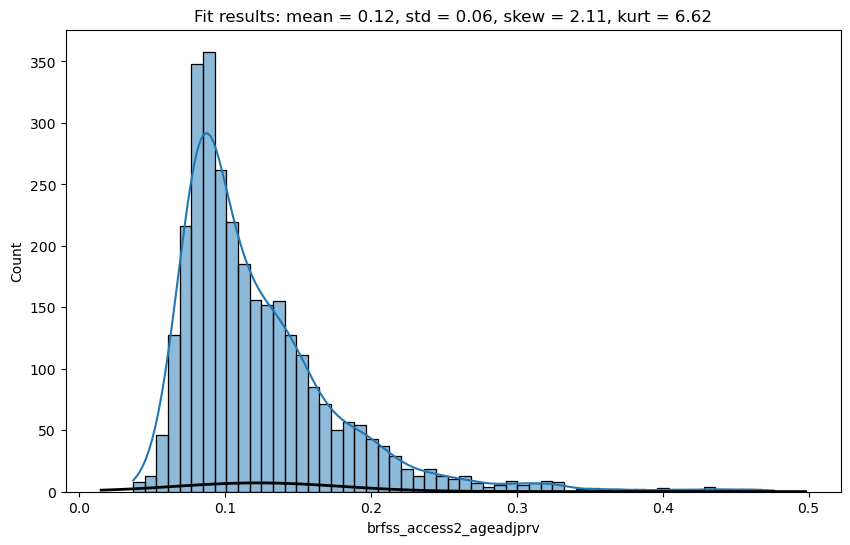

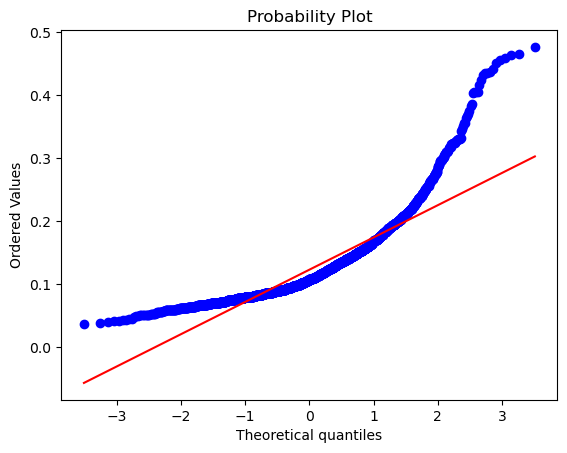

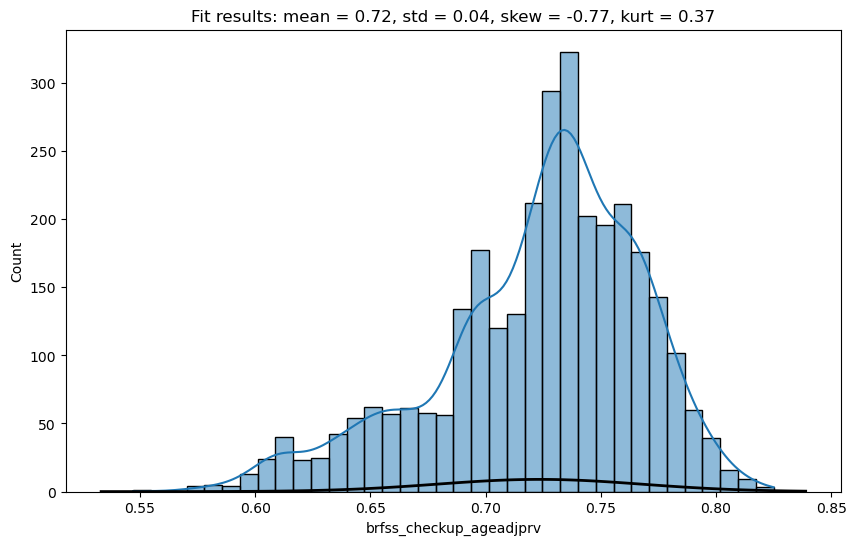

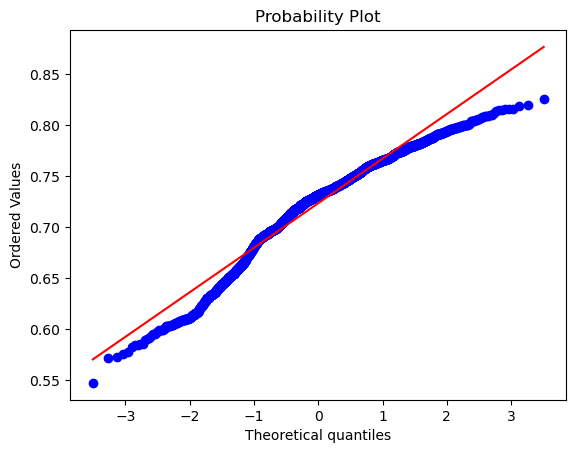

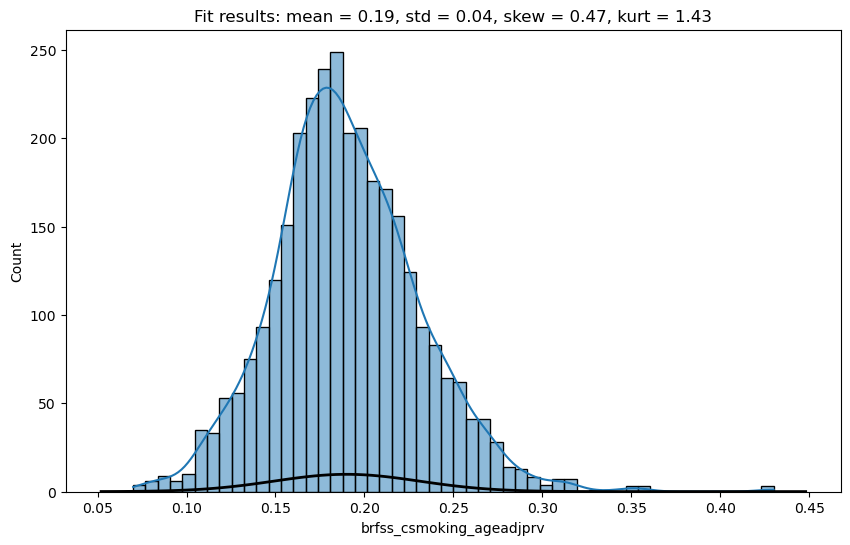

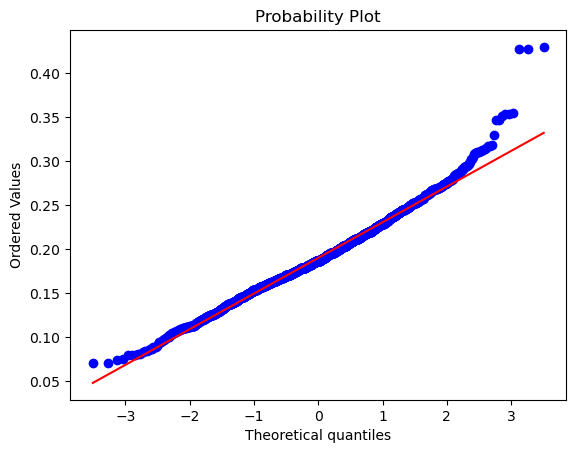

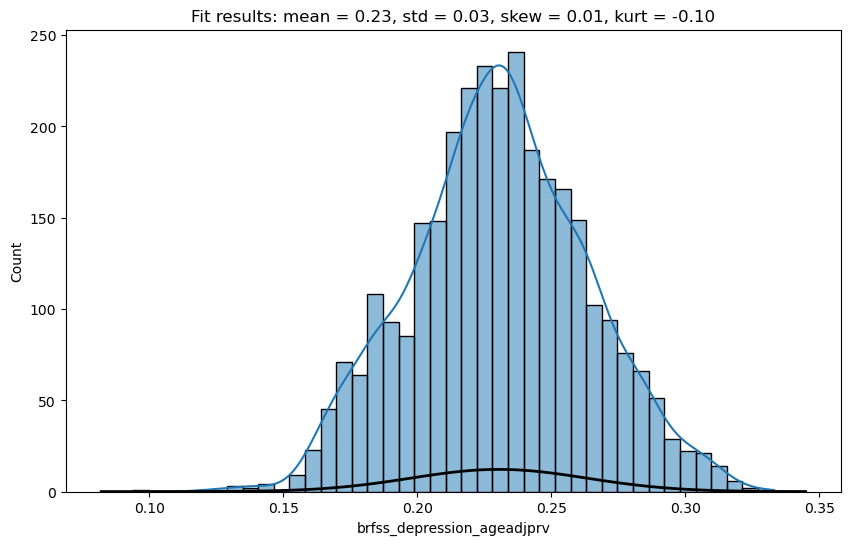

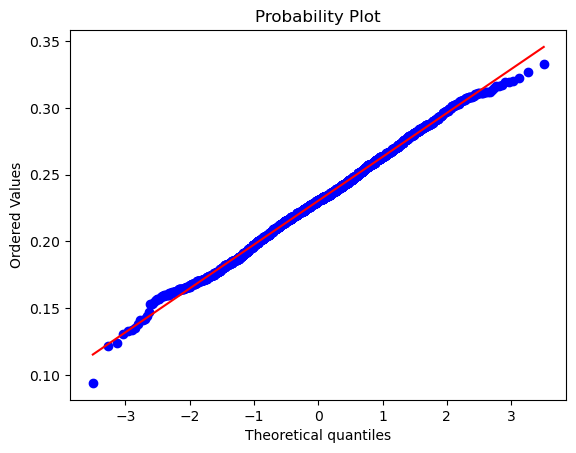

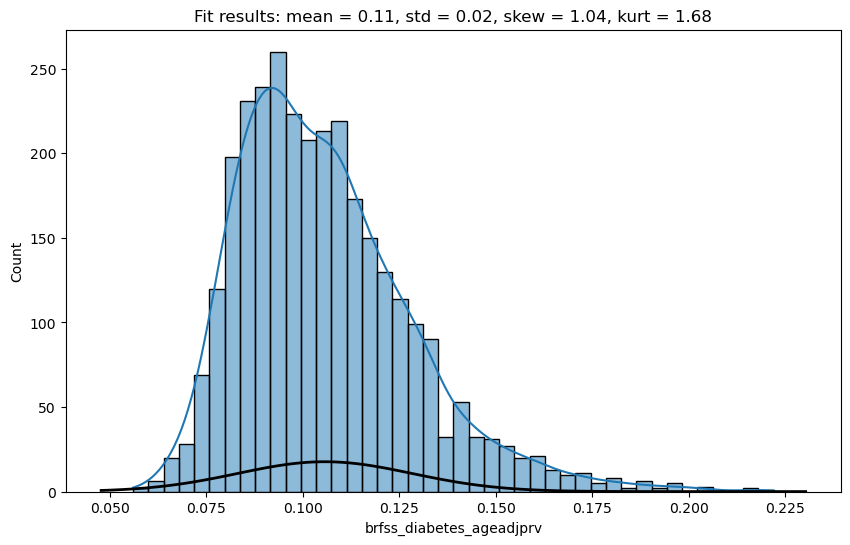

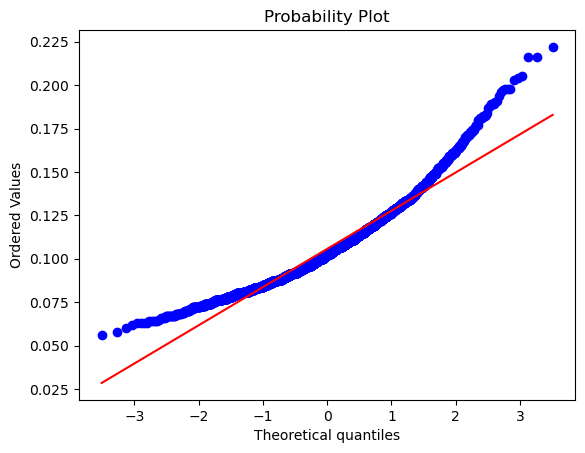

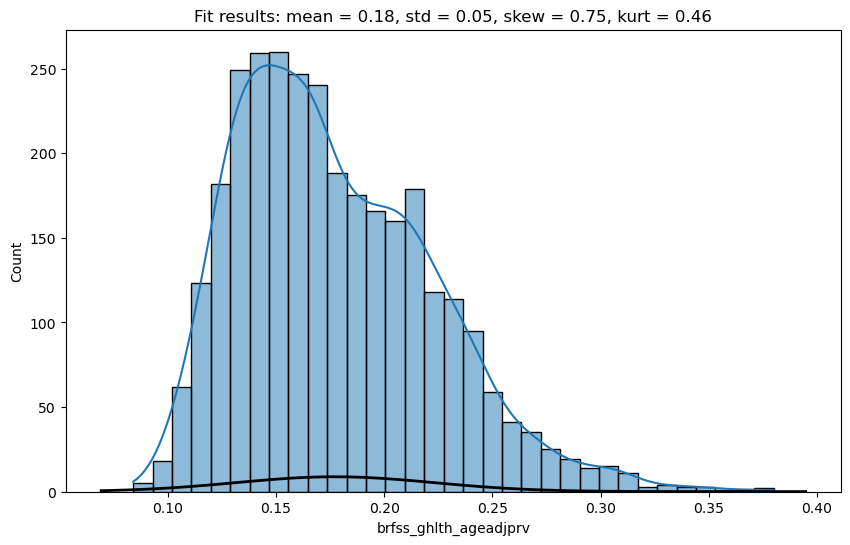

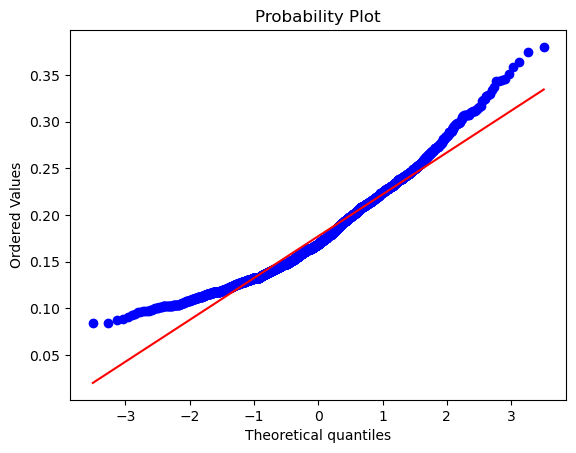

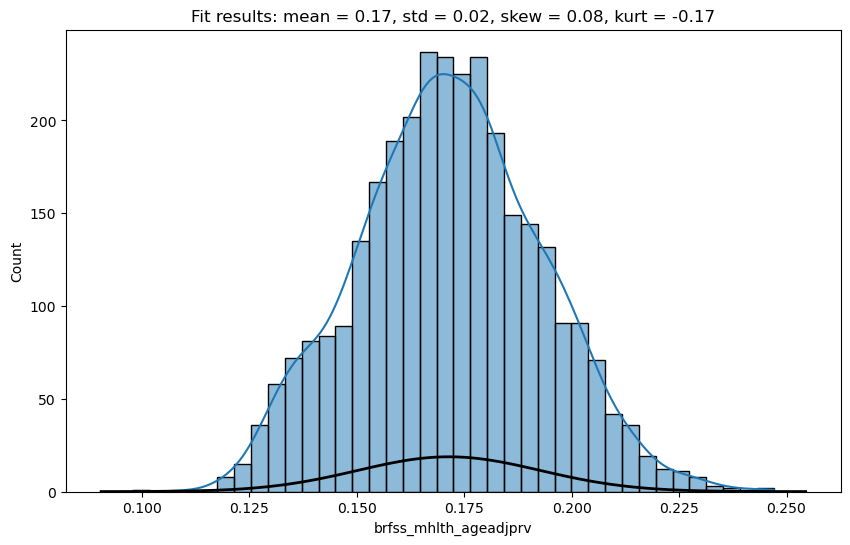

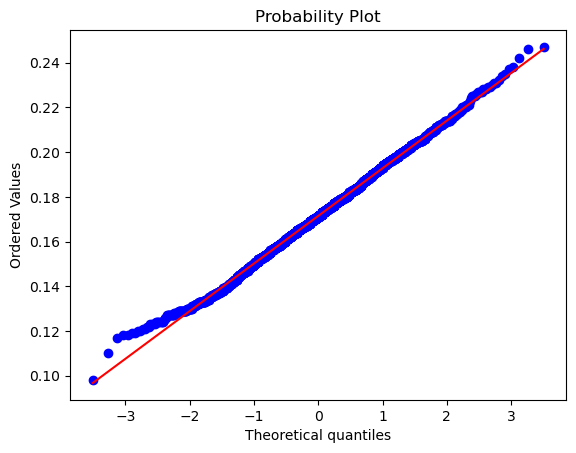

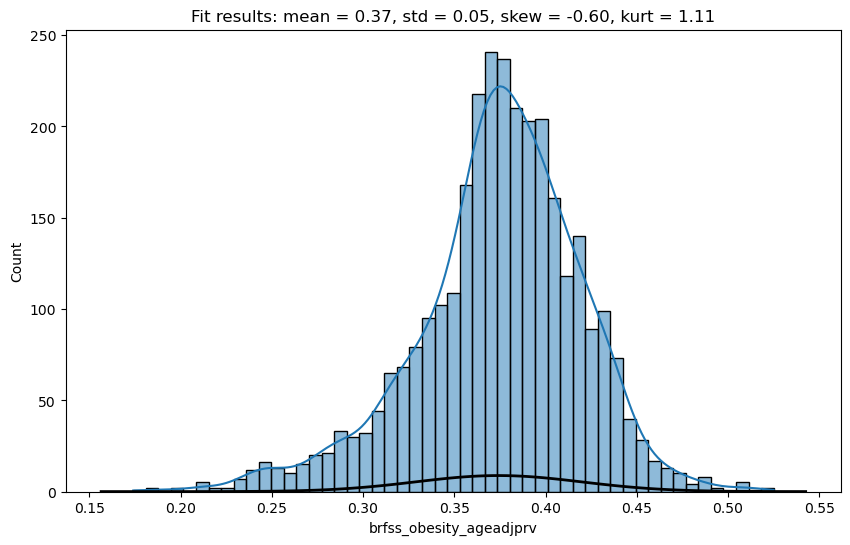

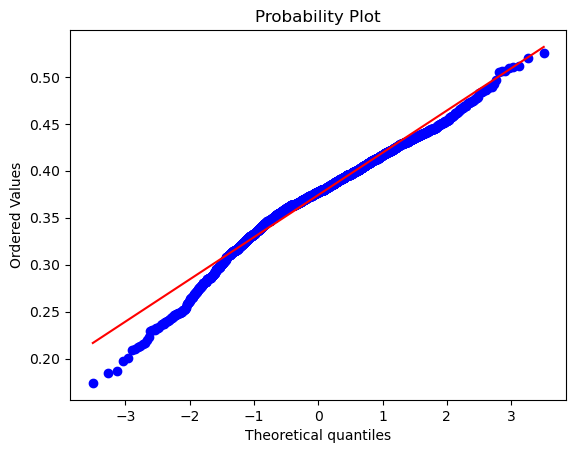

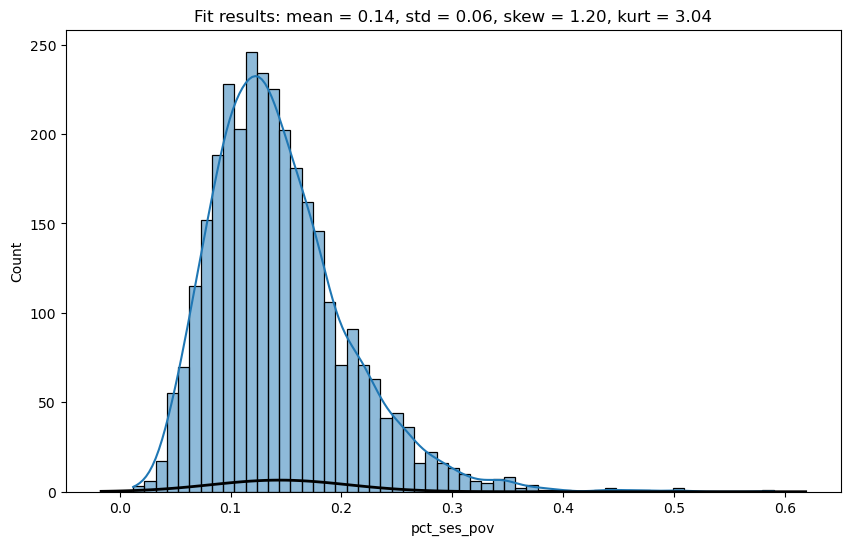

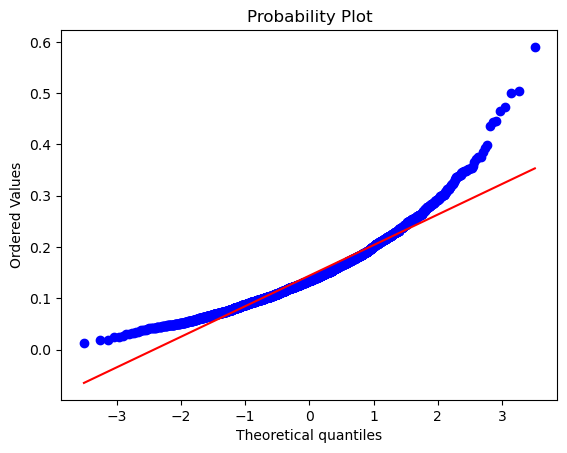

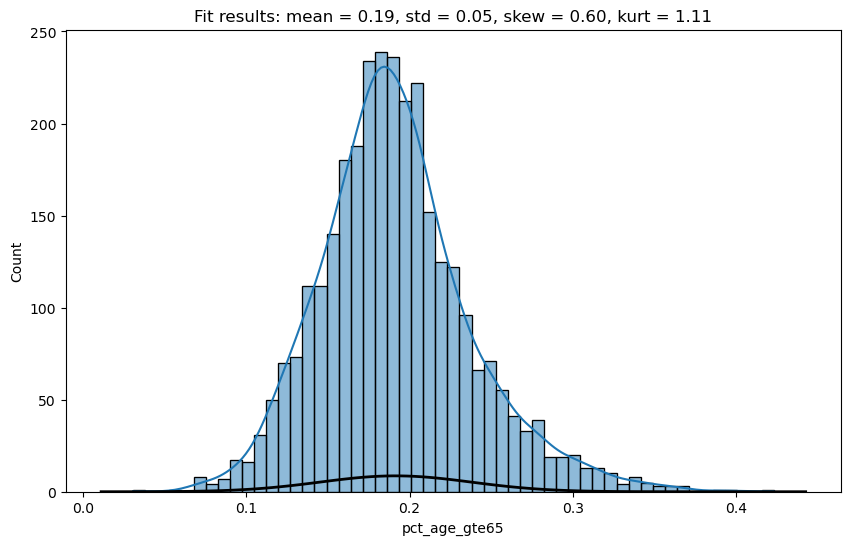

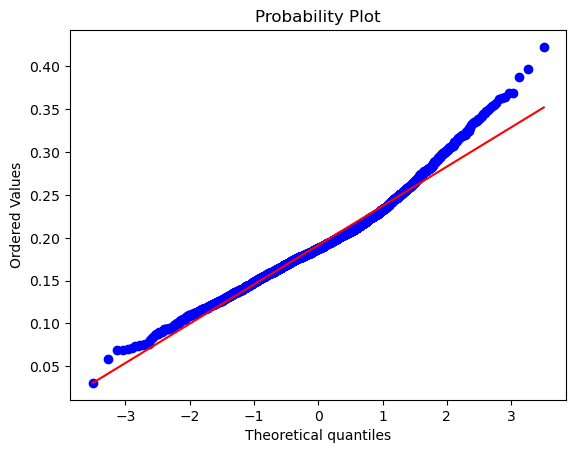

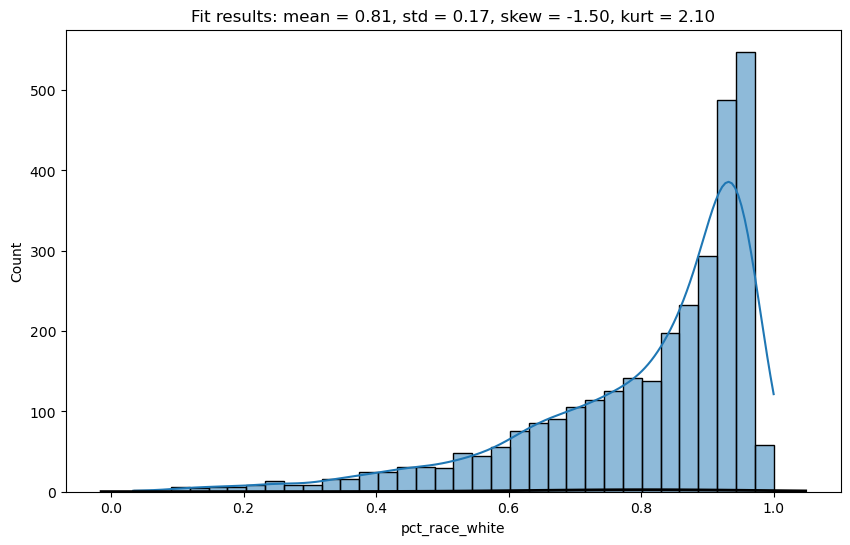

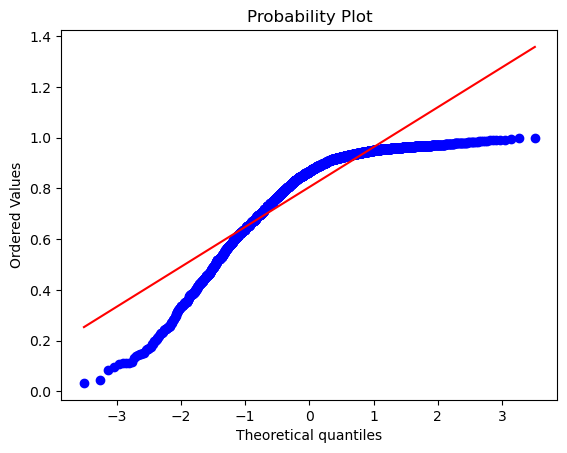

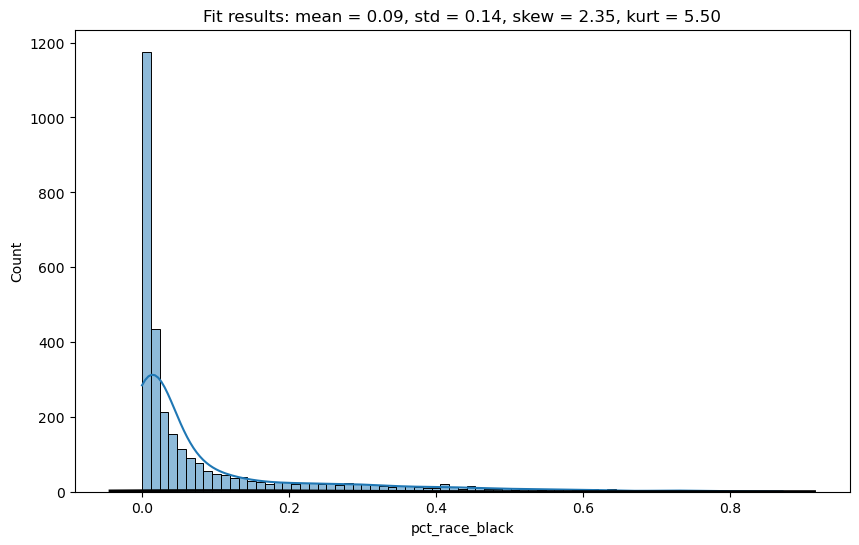

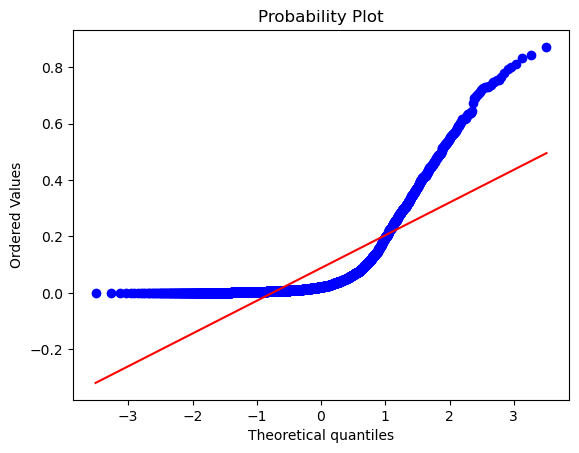

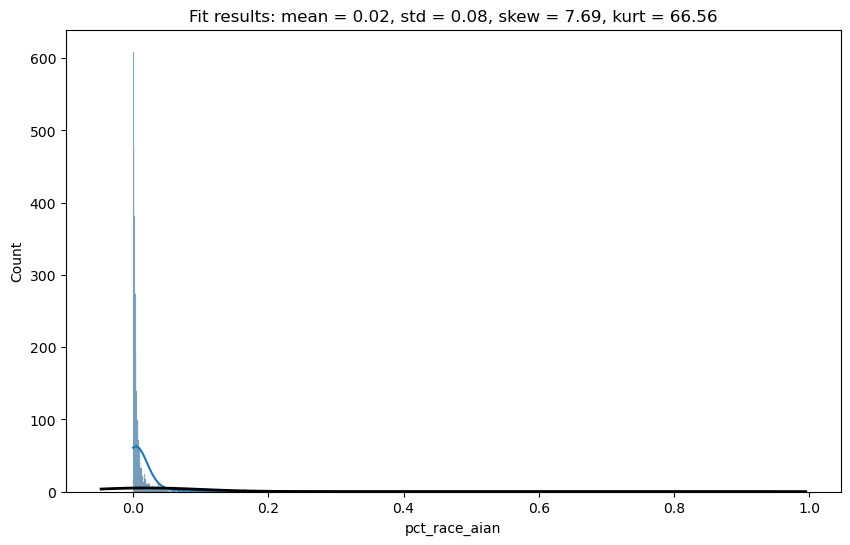

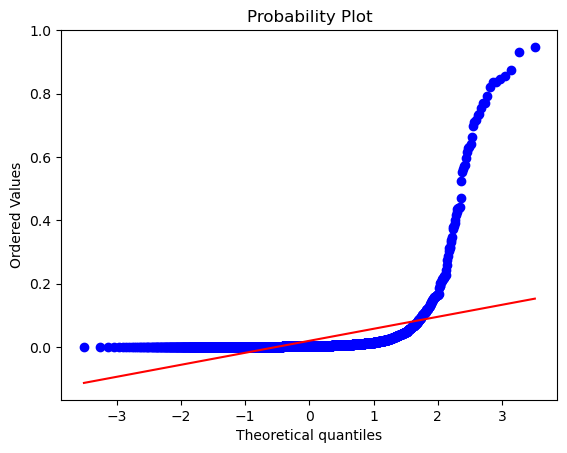

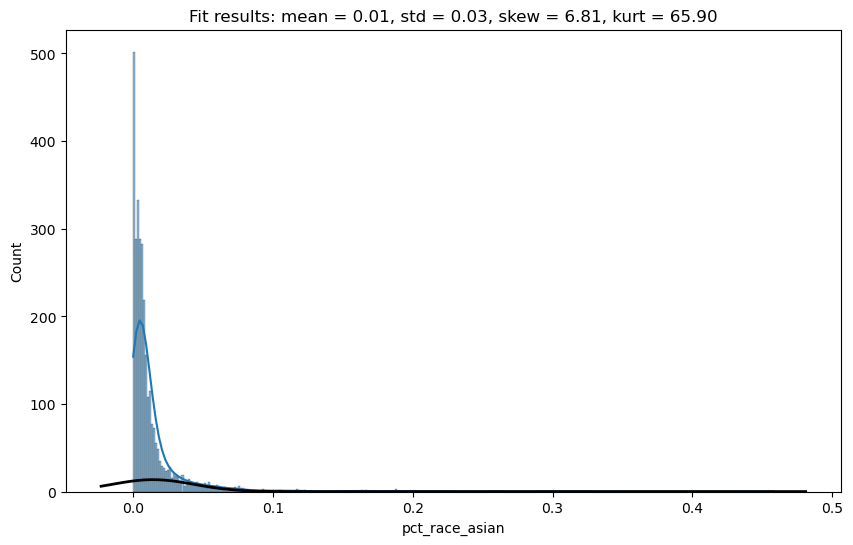

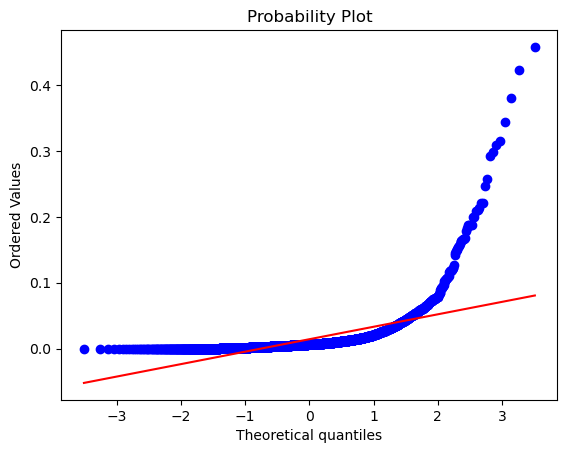

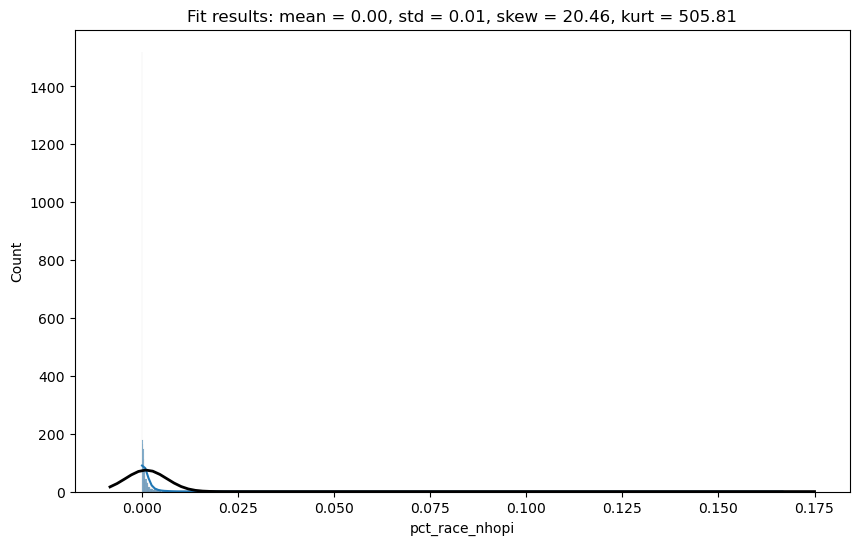

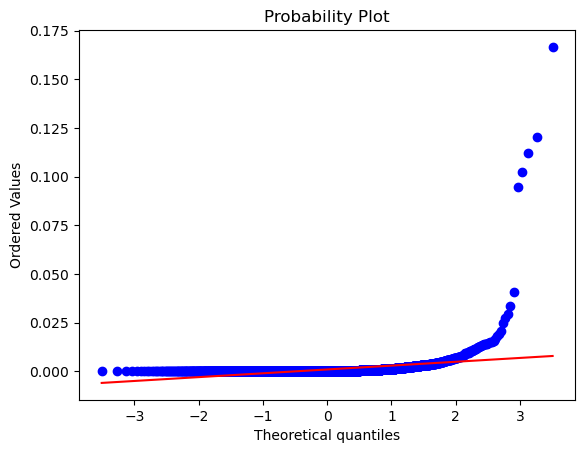

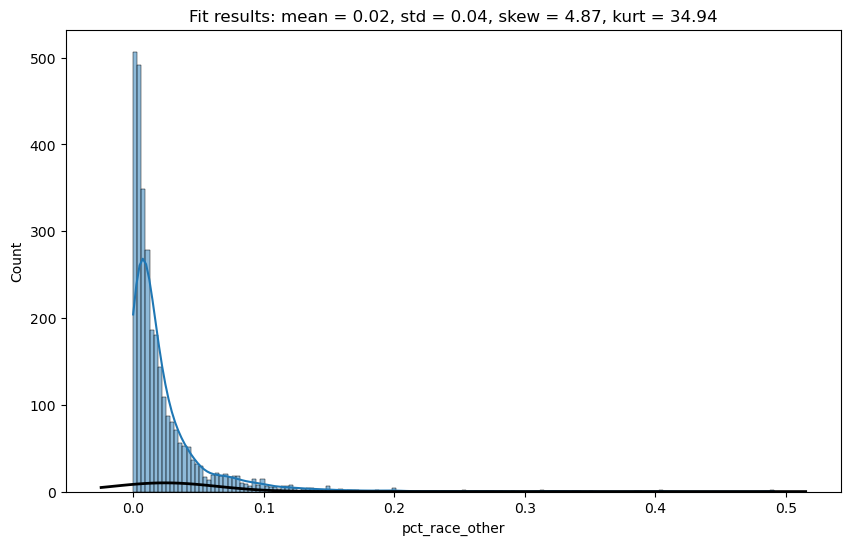

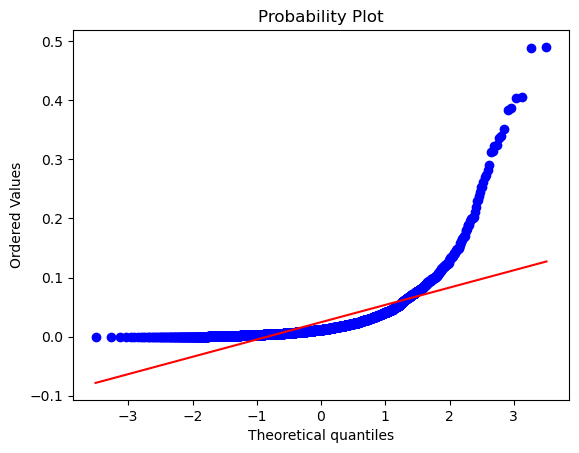

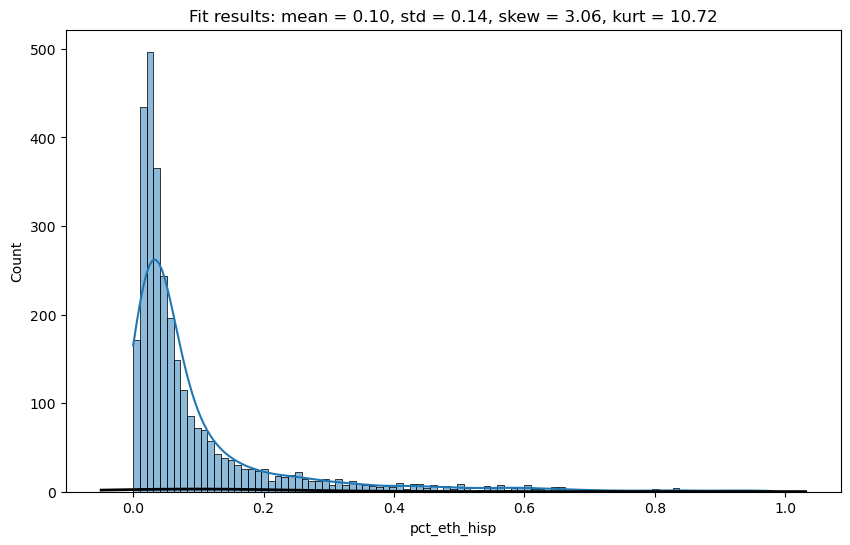

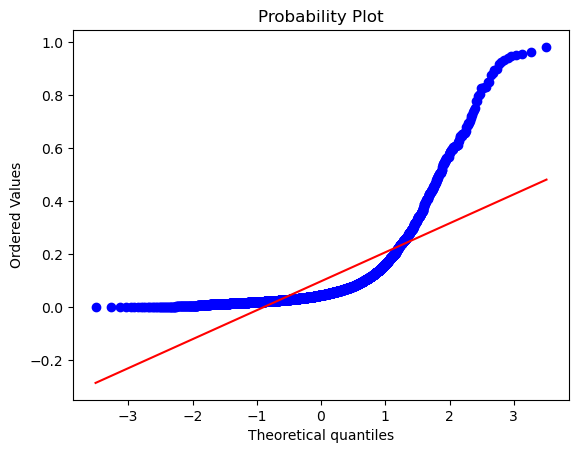

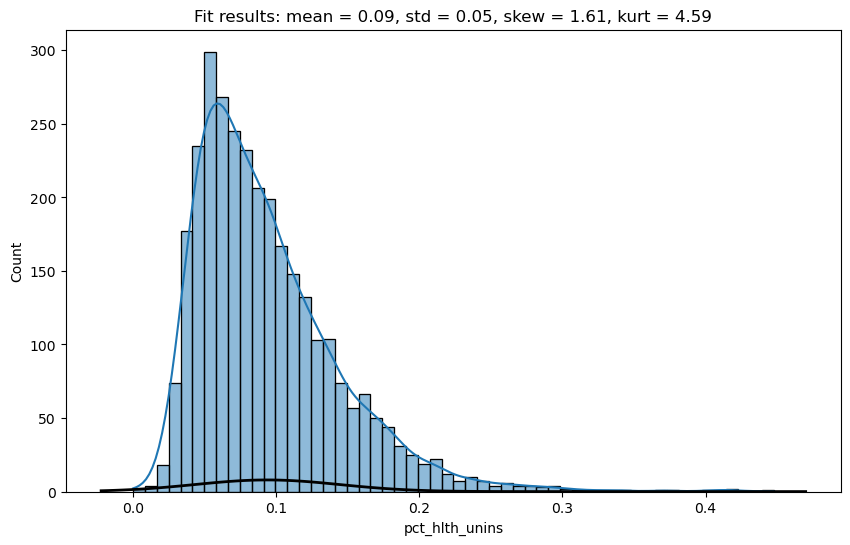

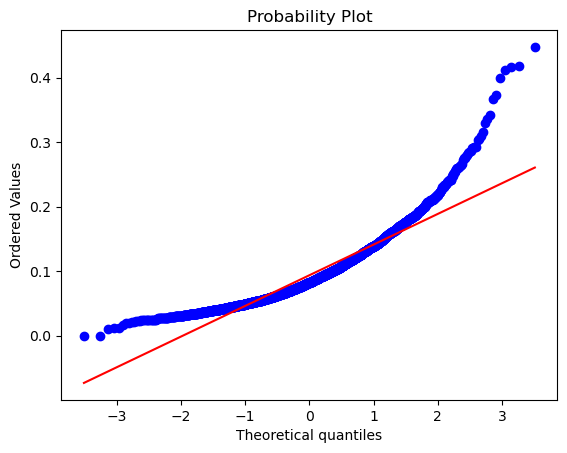

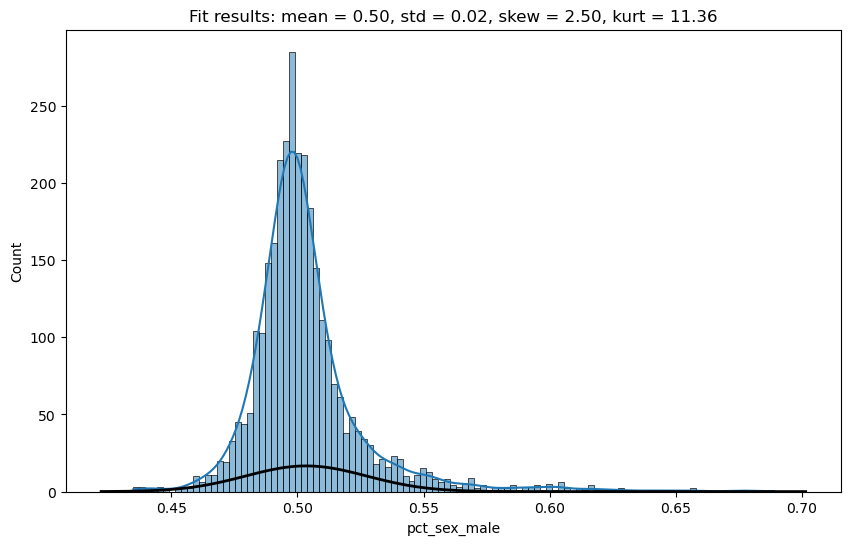

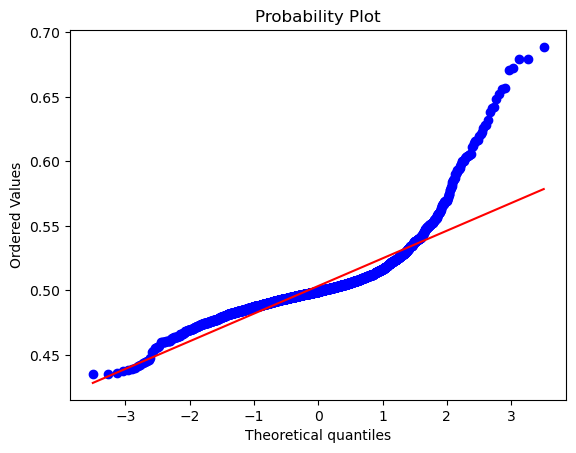

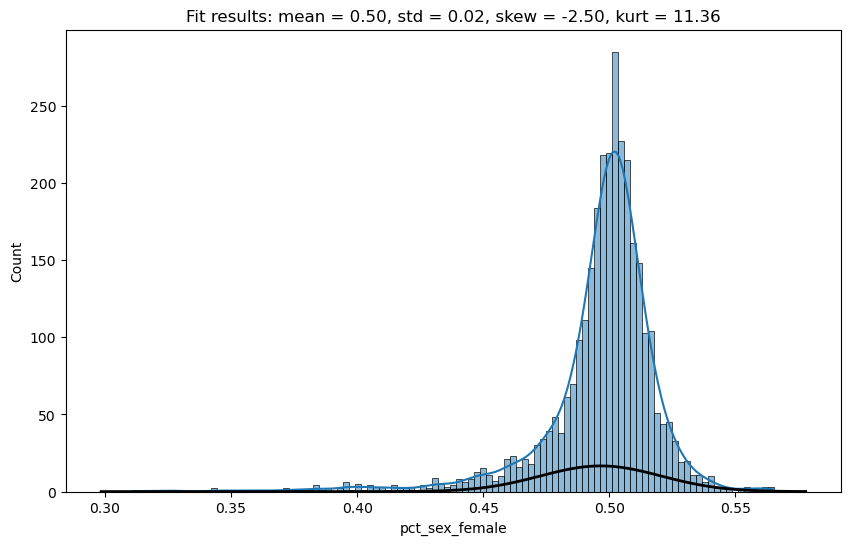

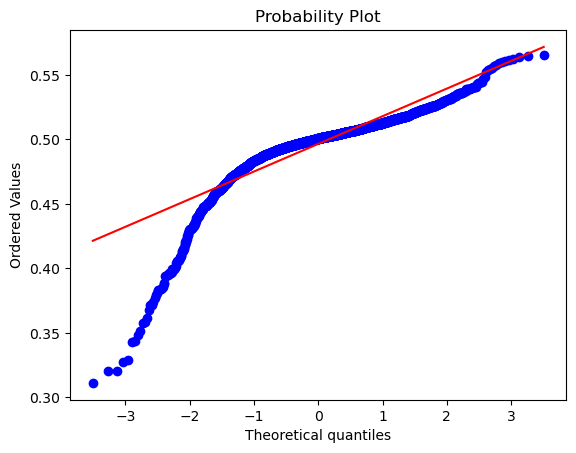

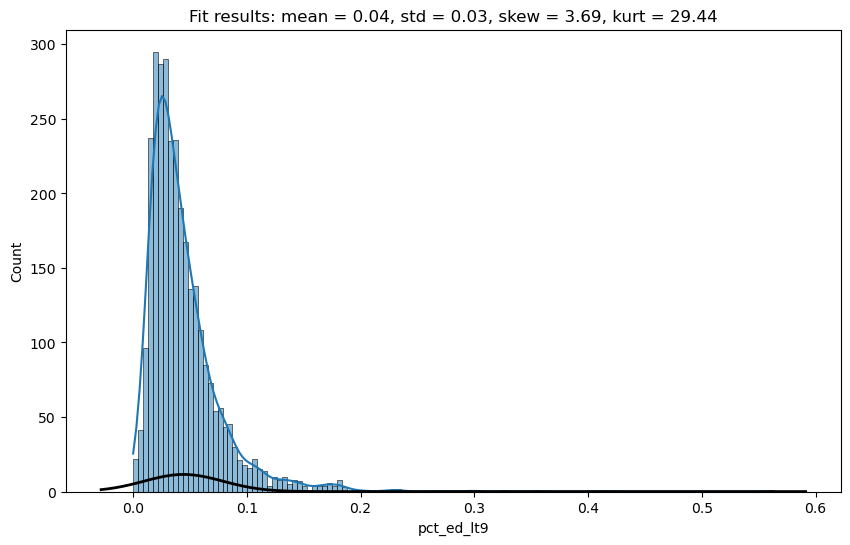

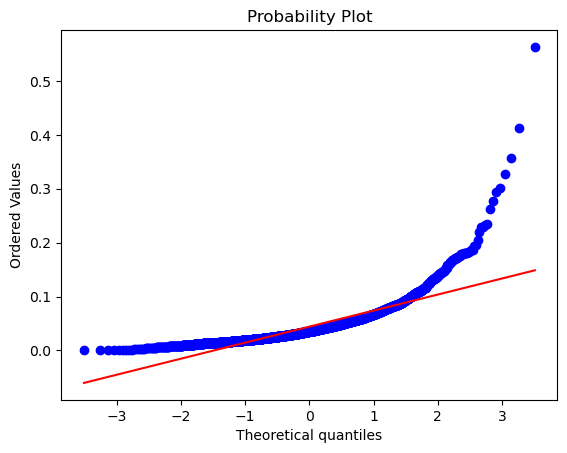

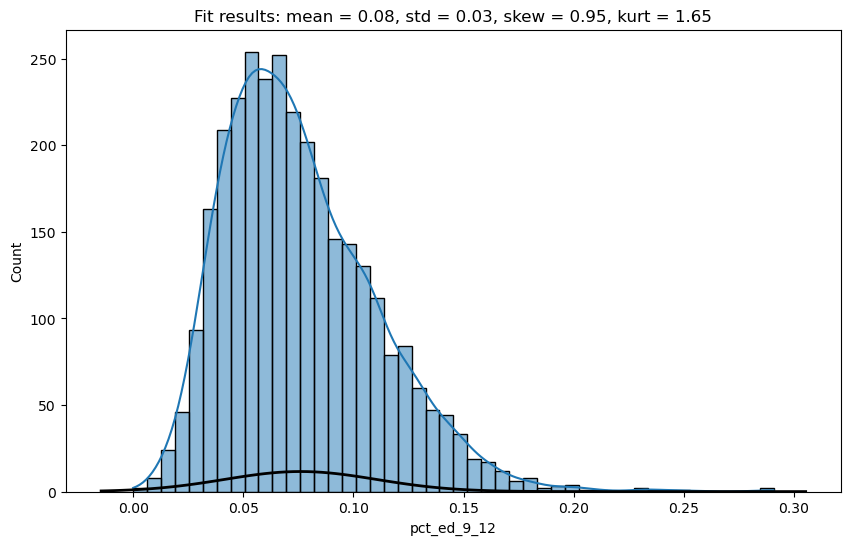

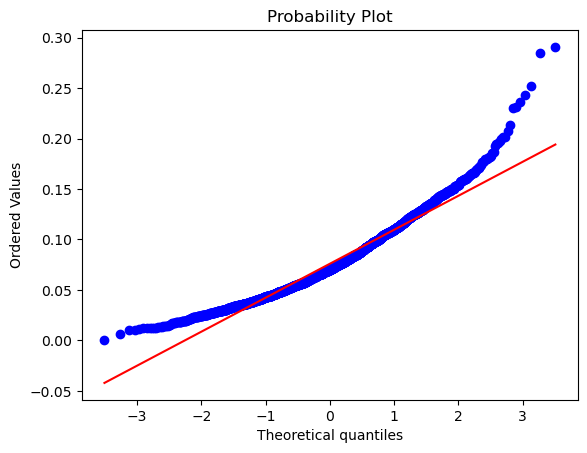

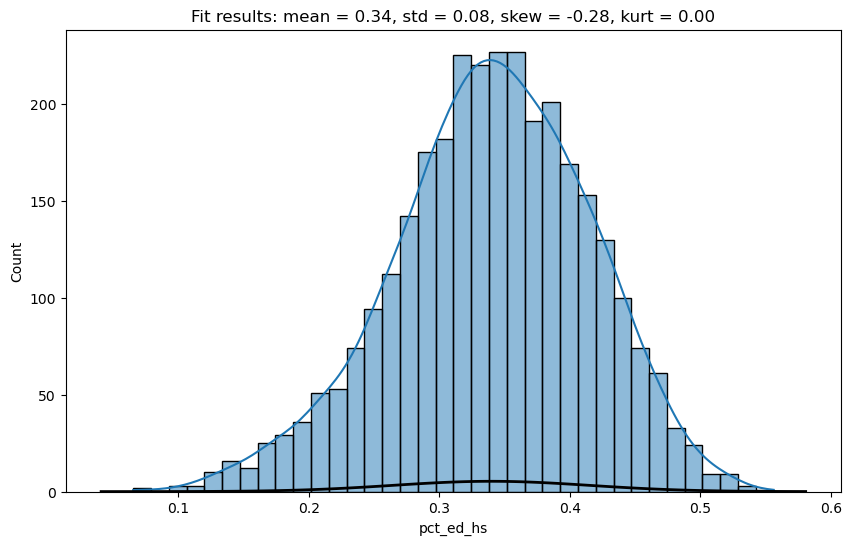

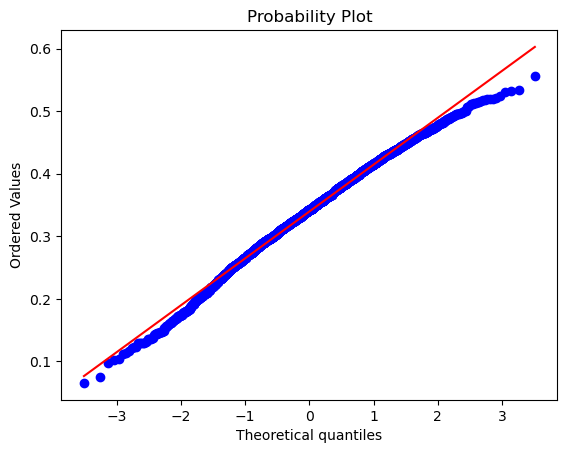

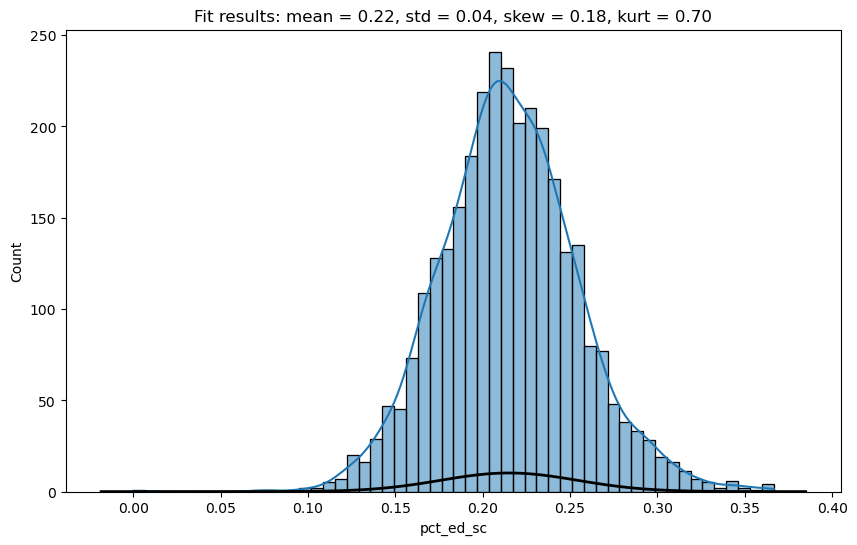

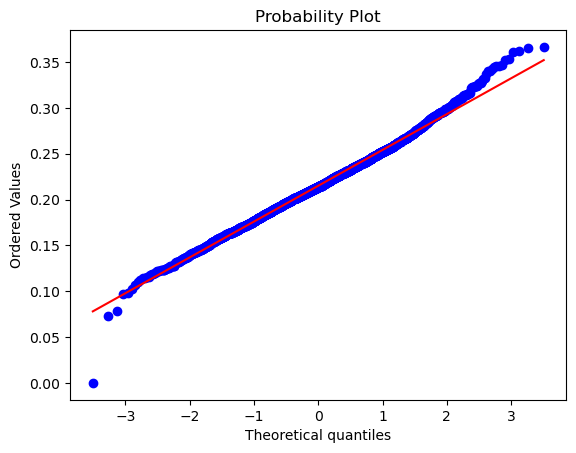

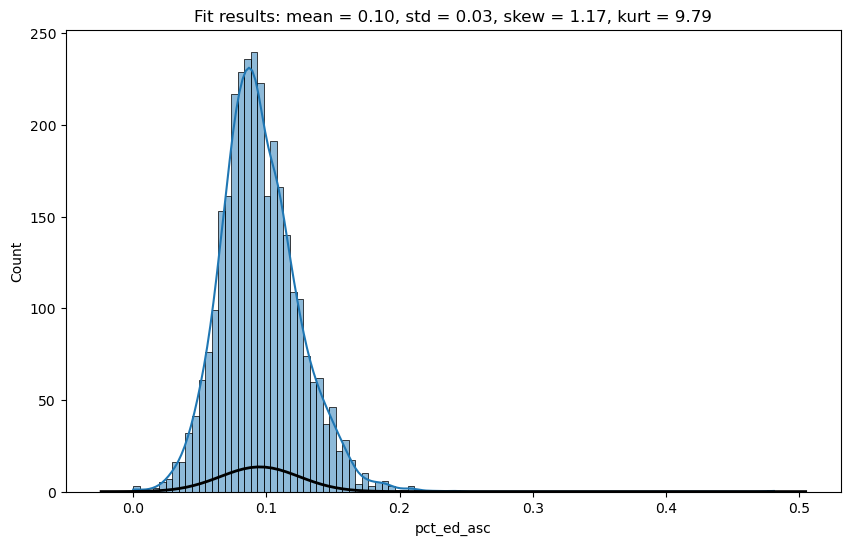

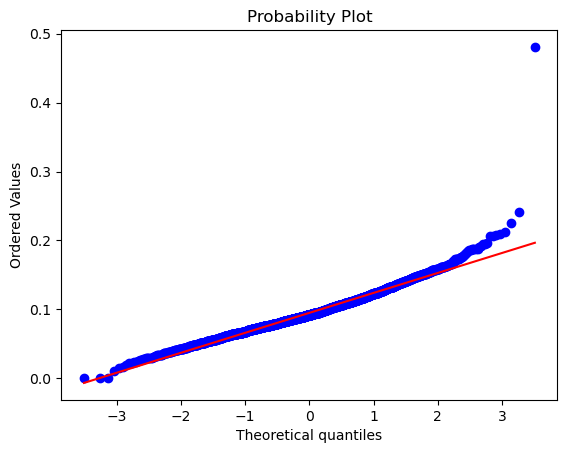

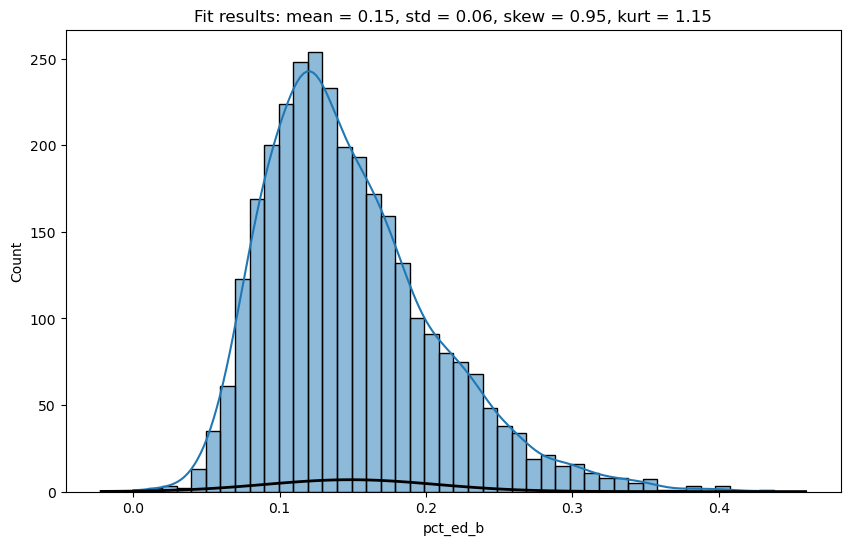

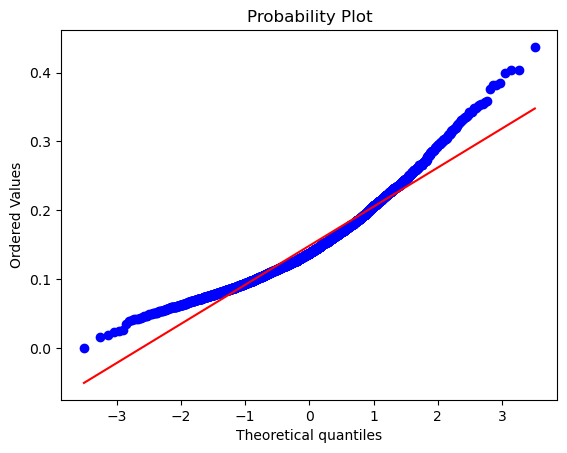

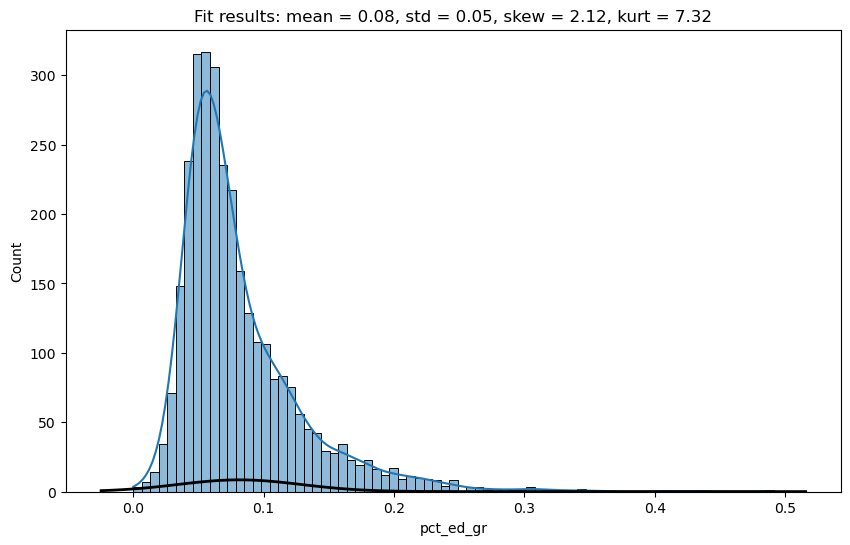

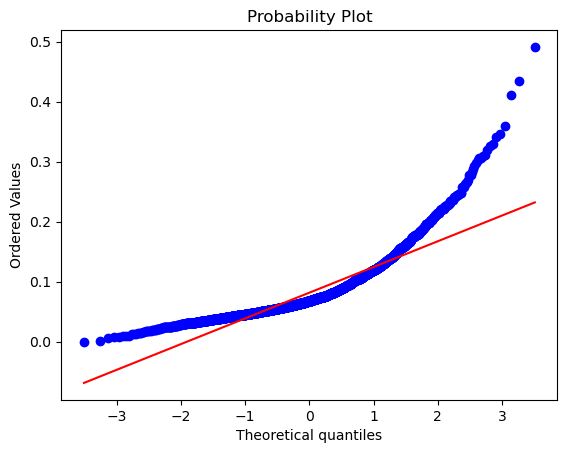

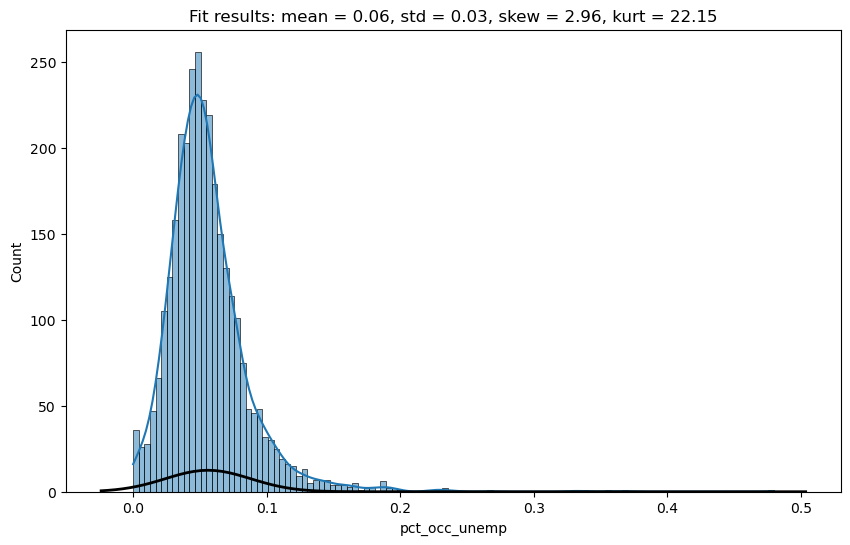

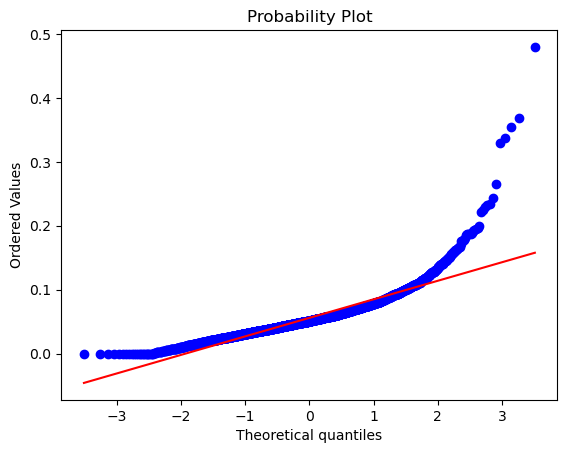

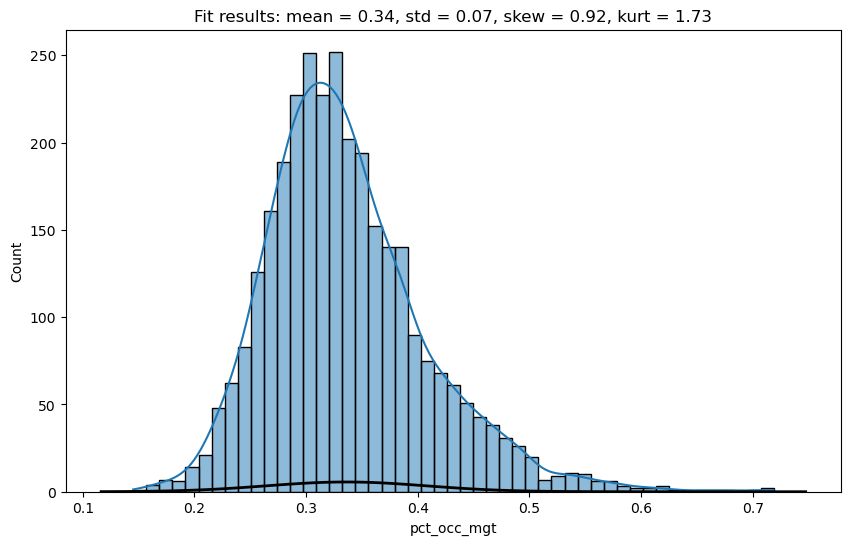

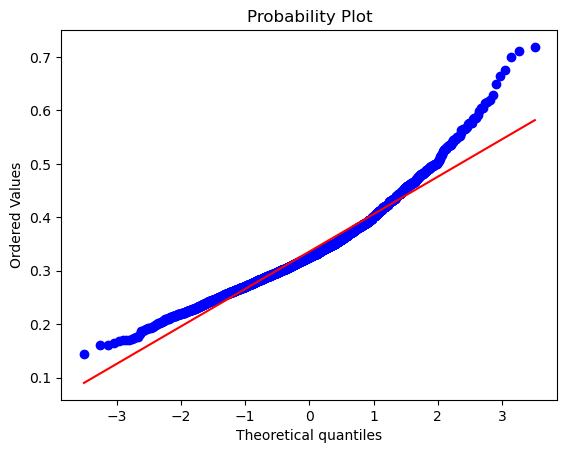

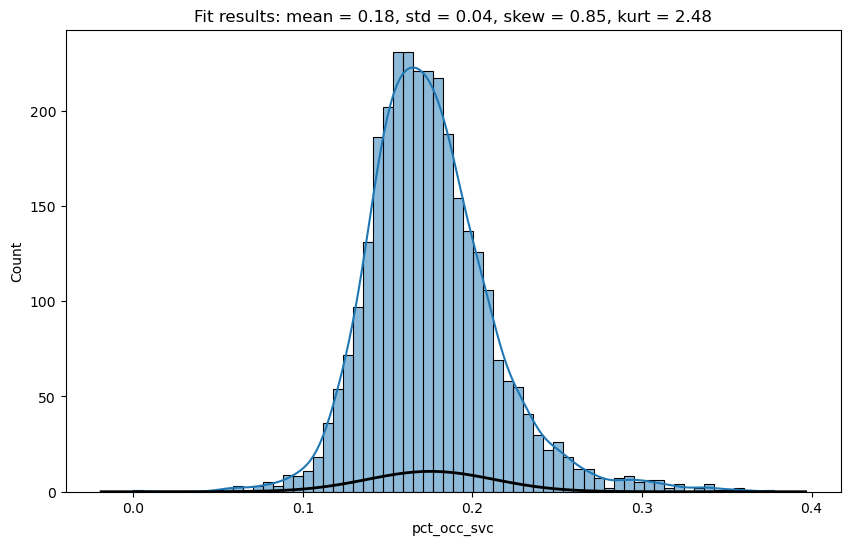

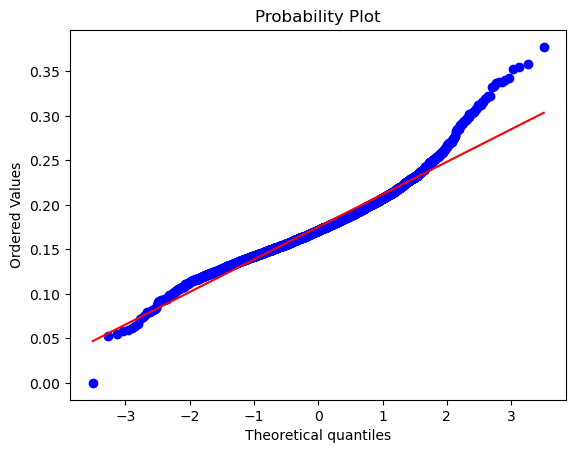

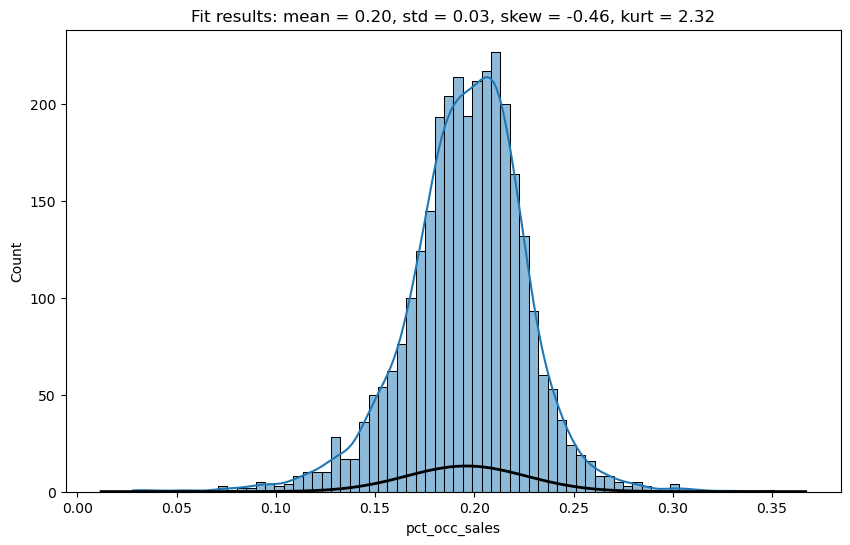

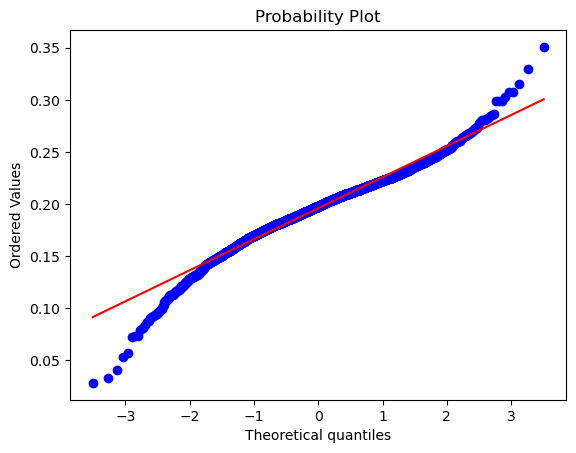

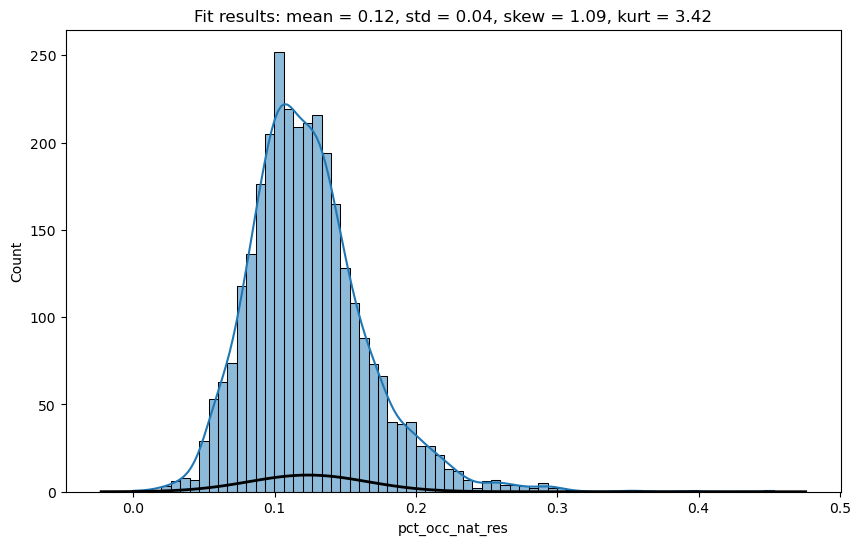

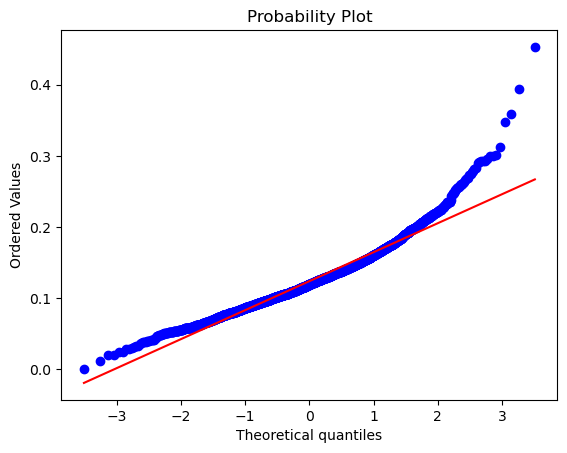

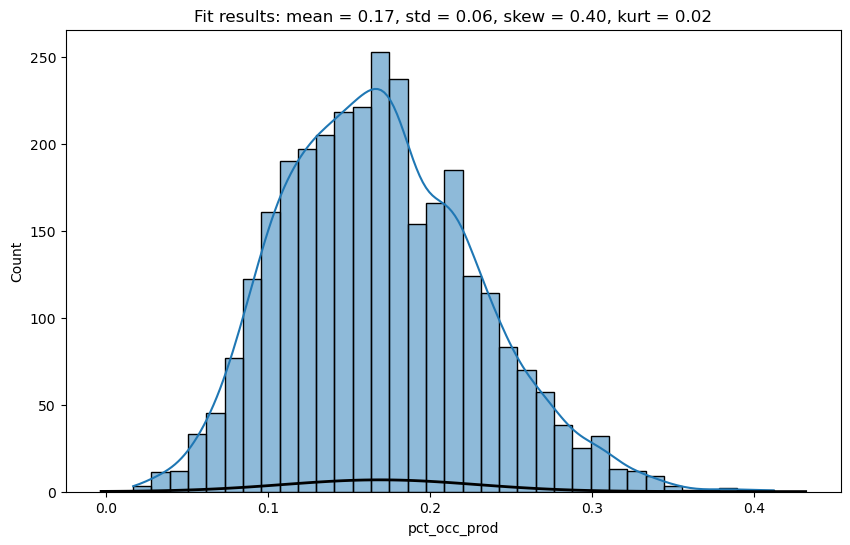

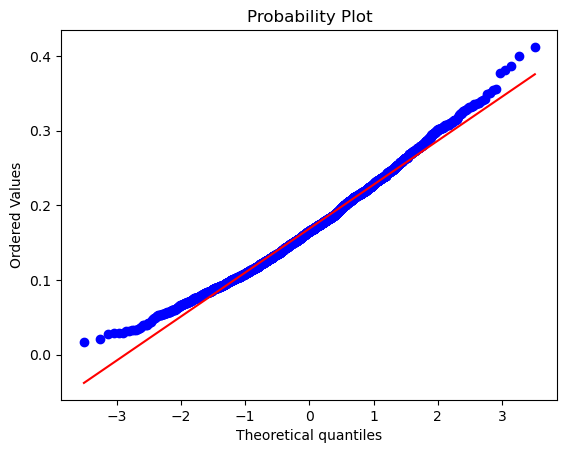

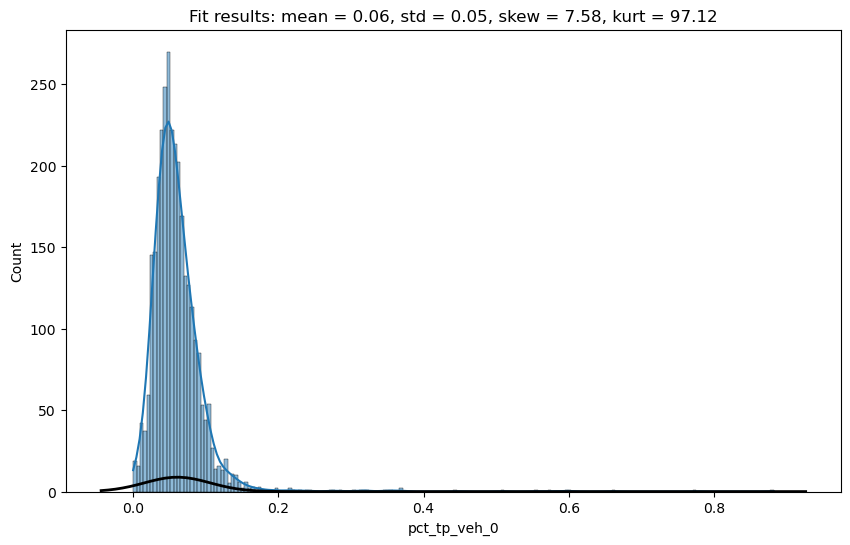

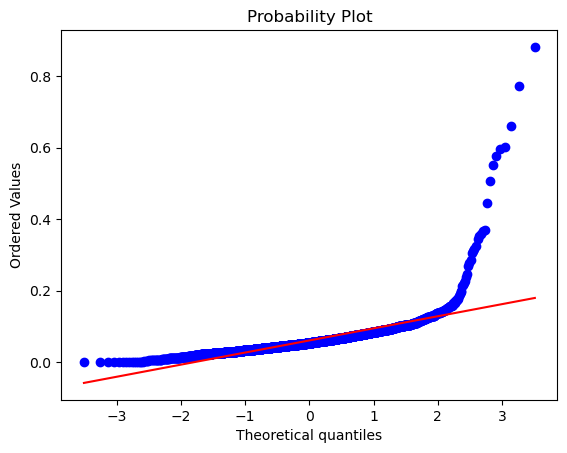

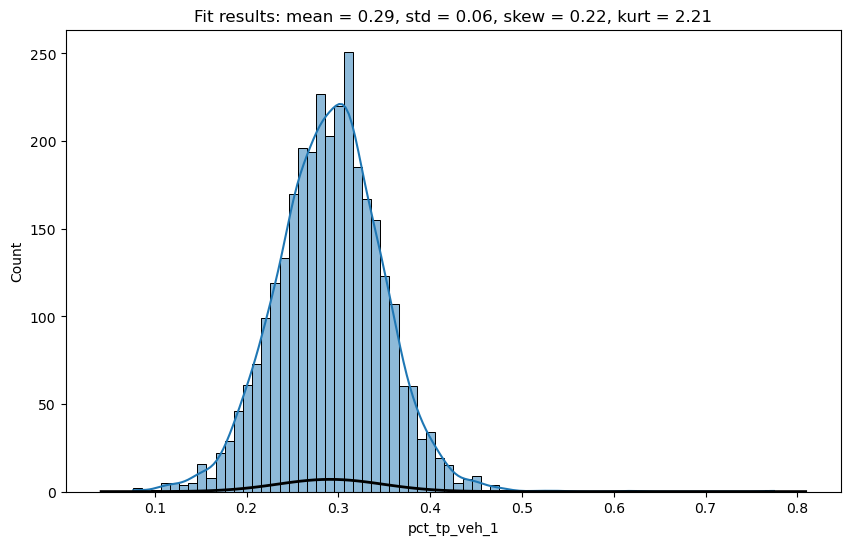

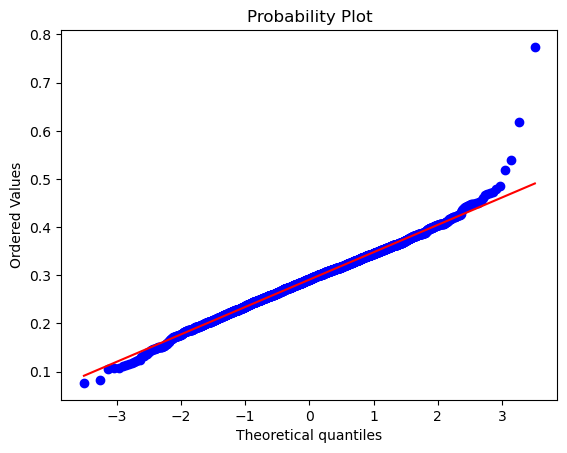

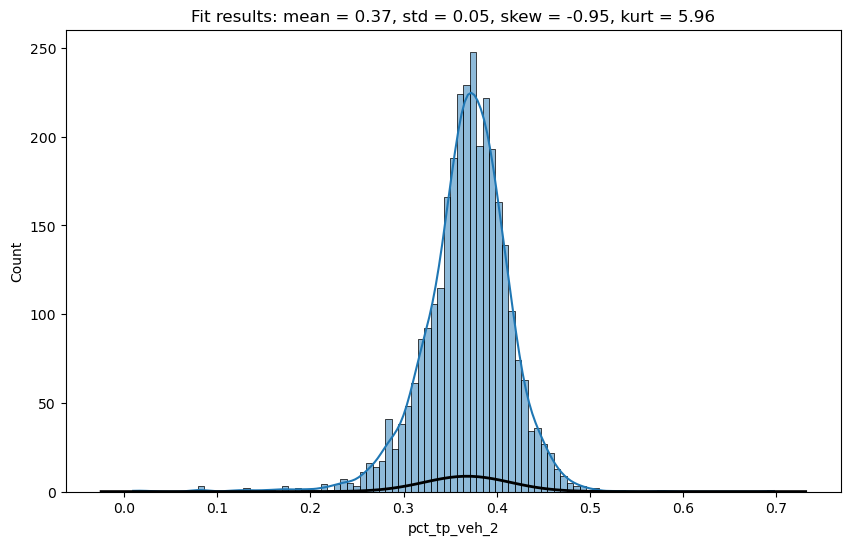

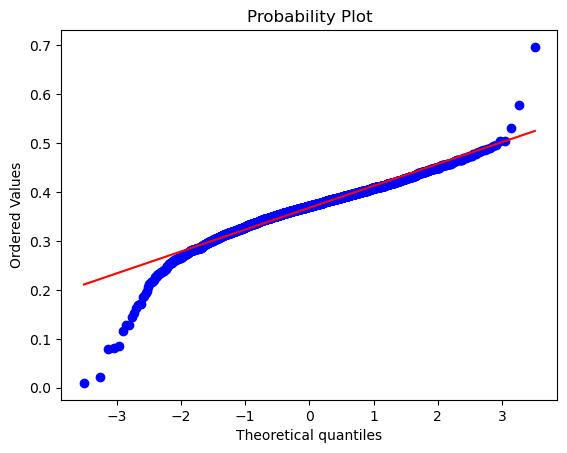

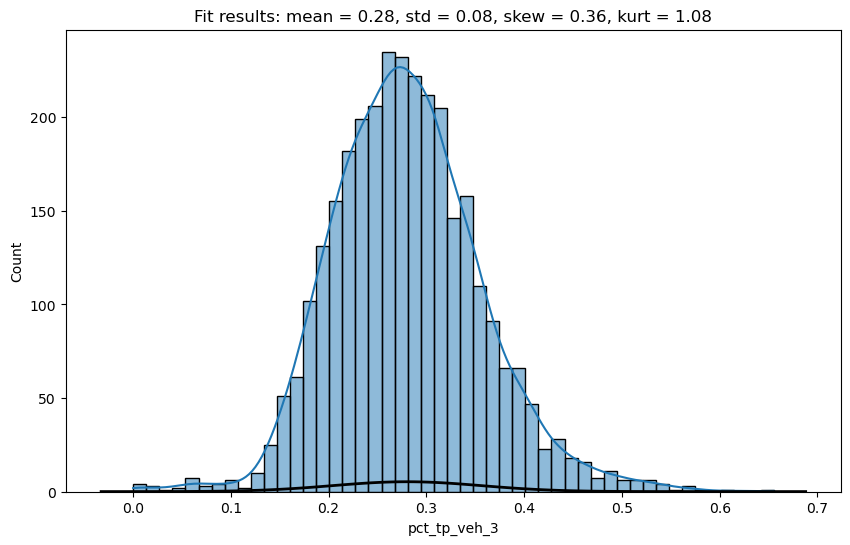

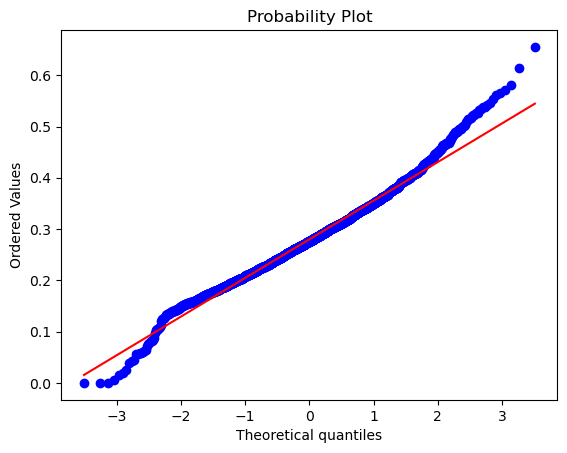

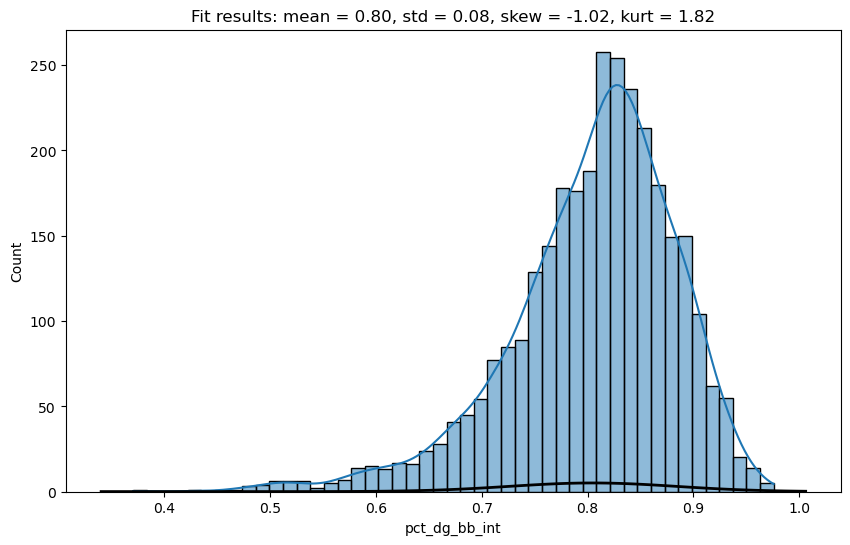

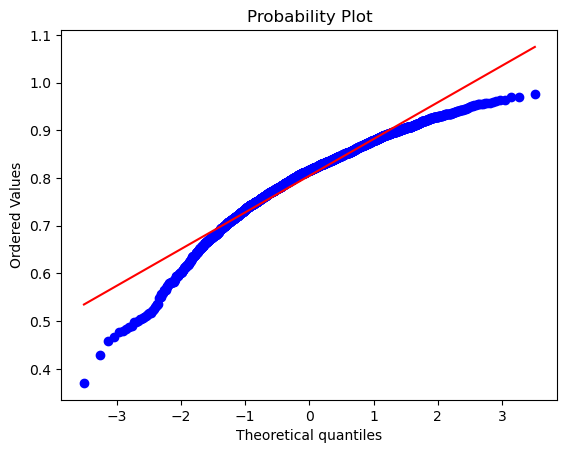

In [282]:
for i in features:
    analyze_distribution(df, i)

## Univariate Analysis - Correlation

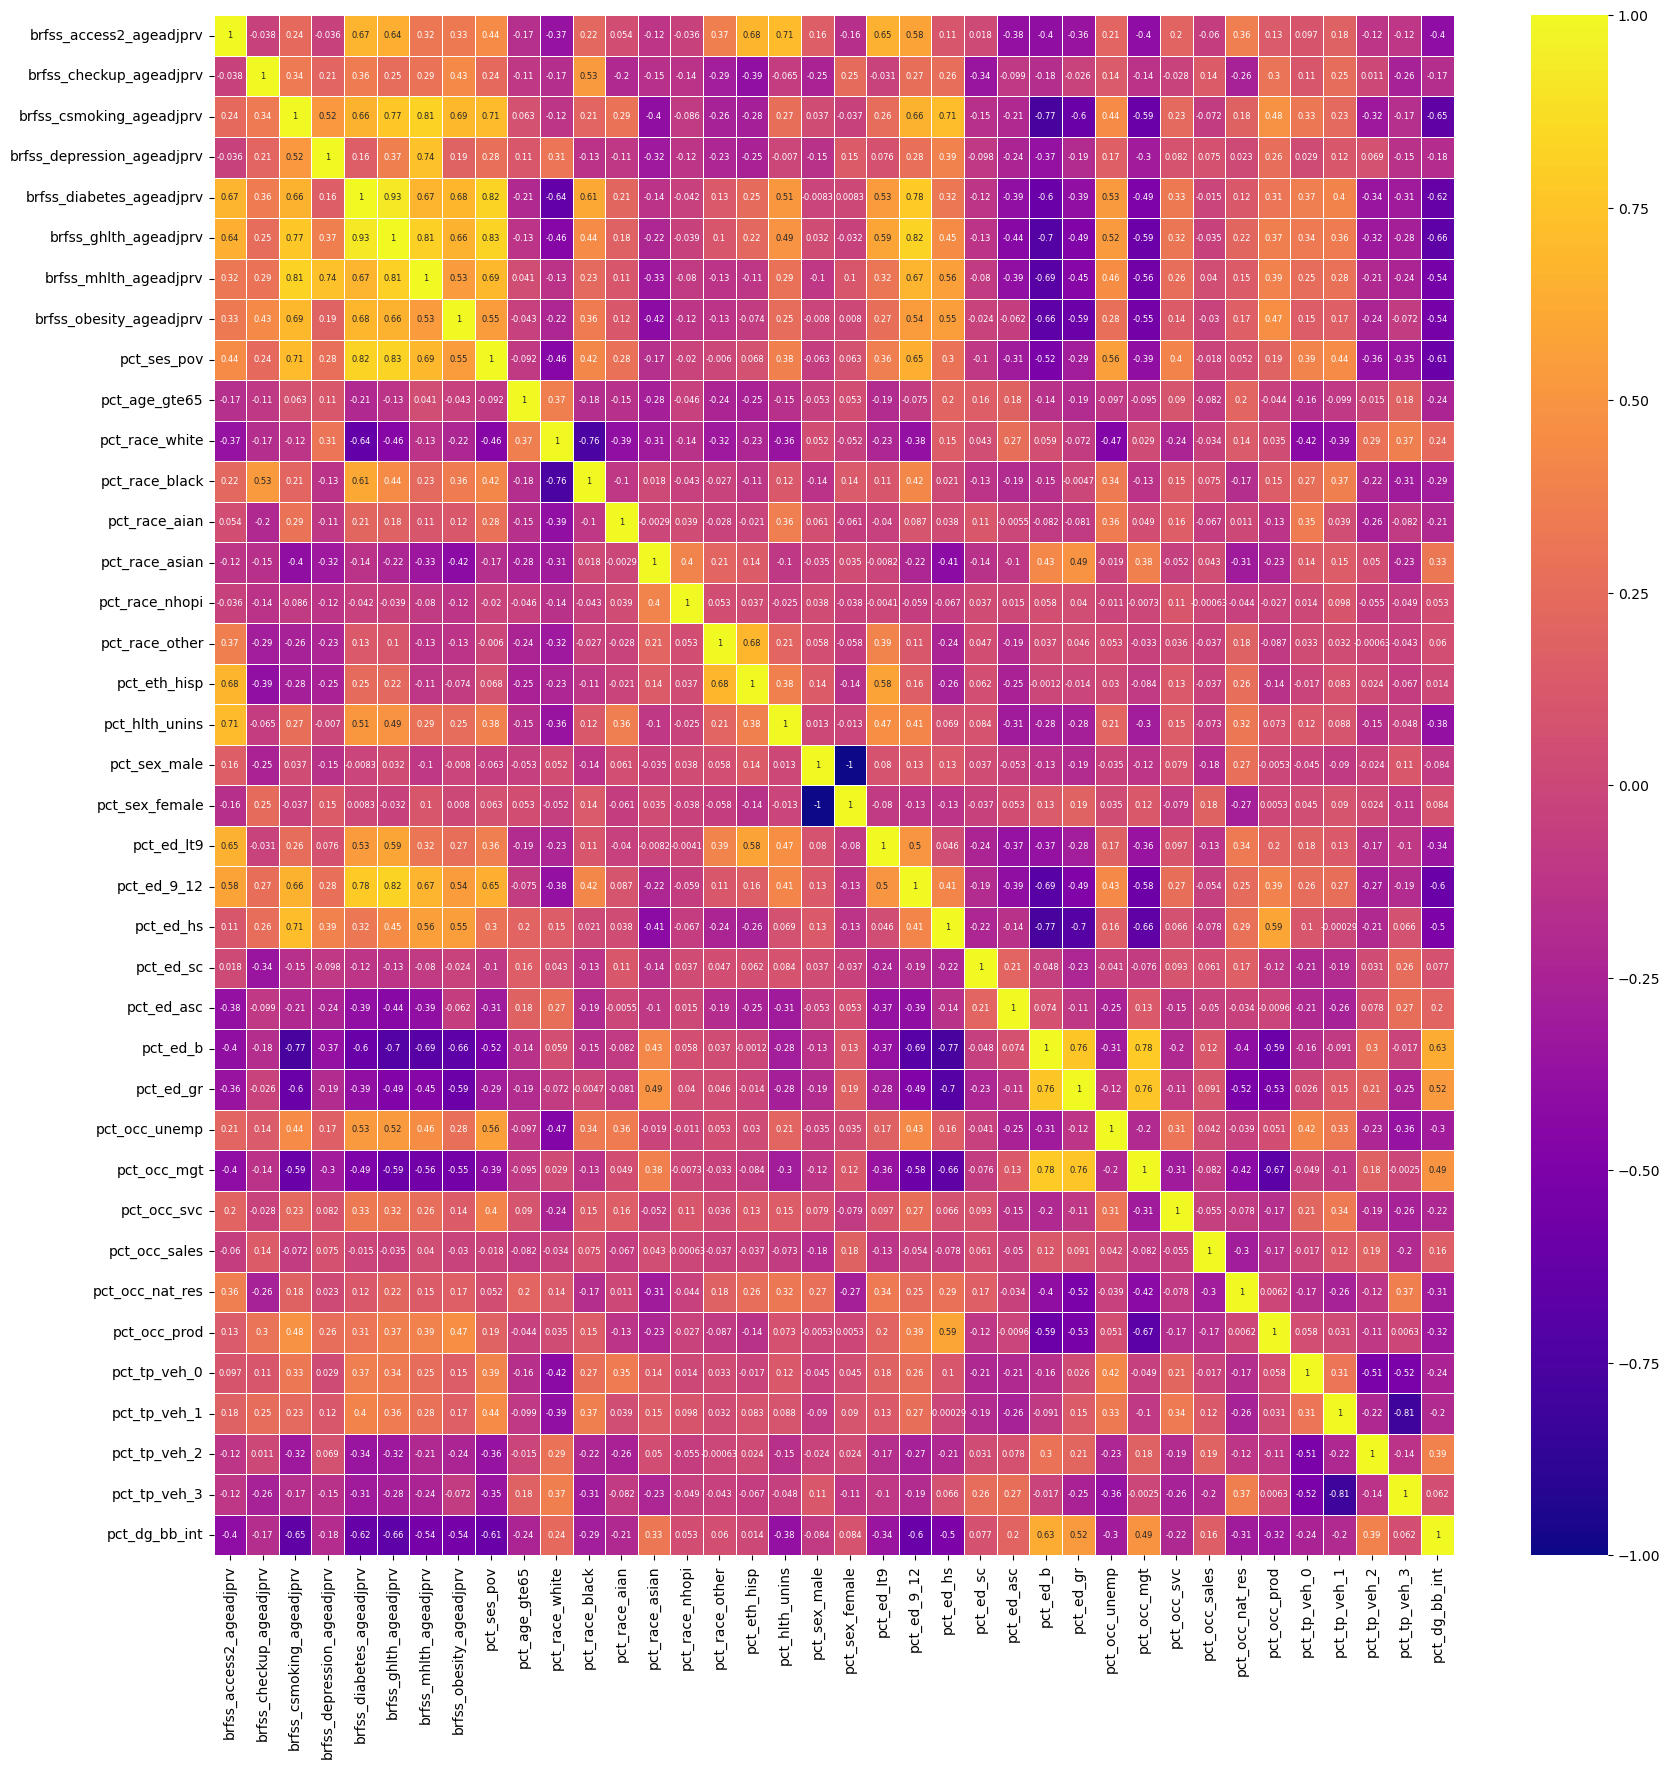

feature1                    feature2  correlation
0             pct_race_other                pct_eth_hisp     0.682375
1   brfss_diabetes_ageadjprv     brfss_obesity_ageadjprv     0.683073
2                pct_ses_pov       brfss_mhlth_ageadjprv     0.688144
3    brfss_obesity_ageadjprv    brfss_csmoking_ageadjprv     0.692554
4             pct_hlth_unins     brfss_access2_ageadjprv     0.708481
5   brfss_csmoking_ageadjprv                 pct_ses_pov     0.710255
6   brfss_csmoking_ageadjprv                   pct_ed_hs     0.713802
7      brfss_mhlth_ageadjprv  brfss_depression_ageadjprv     0.735761
8                pct_occ_mgt                   pct_ed_gr     0.756585
9                  pct_ed_gr                    pct_ed_b     0.764370
10  brfss_csmoking_ageadjprv       brfss_ghlth_ageadjprv     0.769268
11  brfss_diabetes_ageadjprv                 pct_ed_9_12     0.776377
12               pct_occ_mgt                    pct_ed_b     0.777733
13     brfss_ghlth_ageadjprv       brfss_mhlth_ageadjprv     0.812276
14     brfss_mhlth_ageadjprv    brfss_csmoking_ageadjprv     0.813041
15               pct_ed_9_12       brfss_ghlth_ageadjprv     0.820576
16               pct_ses_pov    brfss_diabetes_ageadjprv     0.824549
17               pct_ses_pov       brfss_ghlth_ageadjprv     0.827998
18     brfss_ghlth_ageadjprv    brfss_diabetes_ageadjprv     0.927572
19            pct_sex_female                pct_sex_male    -1.000000
20              pct_tp_veh_1                pct_tp_veh_3    -0.807311
21                  pct_ed_b    brfss_csmoking_ageadjprv    -0.771627
22                 pct_ed_hs                    pct_ed_b    -0.770415
23            pct_race_white              pct_race_black    -0.757326
24                  pct_ed_b       brfss_ghlth_ageadjprv    -0.704519
25                 pct_ed_hs                   pct_ed_gr    -0.701587
26                  pct_ed_b       brfss_mhlth_ageadjprv    -0.689818
27                  pct_ed_b                 pct_ed_9_12    -0.689750
28              pct_occ_prod                 pct_occ_mgt    -0.670616
29                  pct_ed_b     brfss_obesity_ageadjprv    -0.662855
30     brfss_ghlth_ageadjprv               pct_dg_bb_int    -0.662491
31                 pct_ed_hs                 pct_occ_mgt    -0.655604
32             pct_dg_bb_int    brfss_csmoking_ageadjprv    -0.653176
33            pct_race_white    brfss_diabetes_ageadjprv    -0.640220
34  brfss_diabetes_ageadjprv               pct_dg_bb_int    -0.620418
35             pct_dg_bb_int                 pct_ses_pov    -0.606068
36                 pct_ed_gr    brfss_csmoking_ageadjprv    -0.599625
37             pct_dg_bb_int                 pct_ed_9_12    -0.598463

In [333]:
corr = df[features].corr(numeric_only=True)
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='plasma', linewidths=0.5, annot_kws={'size': 6})
plt.show()

corr = corr.unstack().sort_values(kind='quicksort').drop_duplicates()
top = corr[-20:-1]
bottom = corr[0:19]
top_bottom = pd.concat([top, bottom])
top_bottom = top_bottom.reset_index()
top_bottom.columns = ['feature1', 'feature2', 'correlation']
top_bottom

## Network Analysis

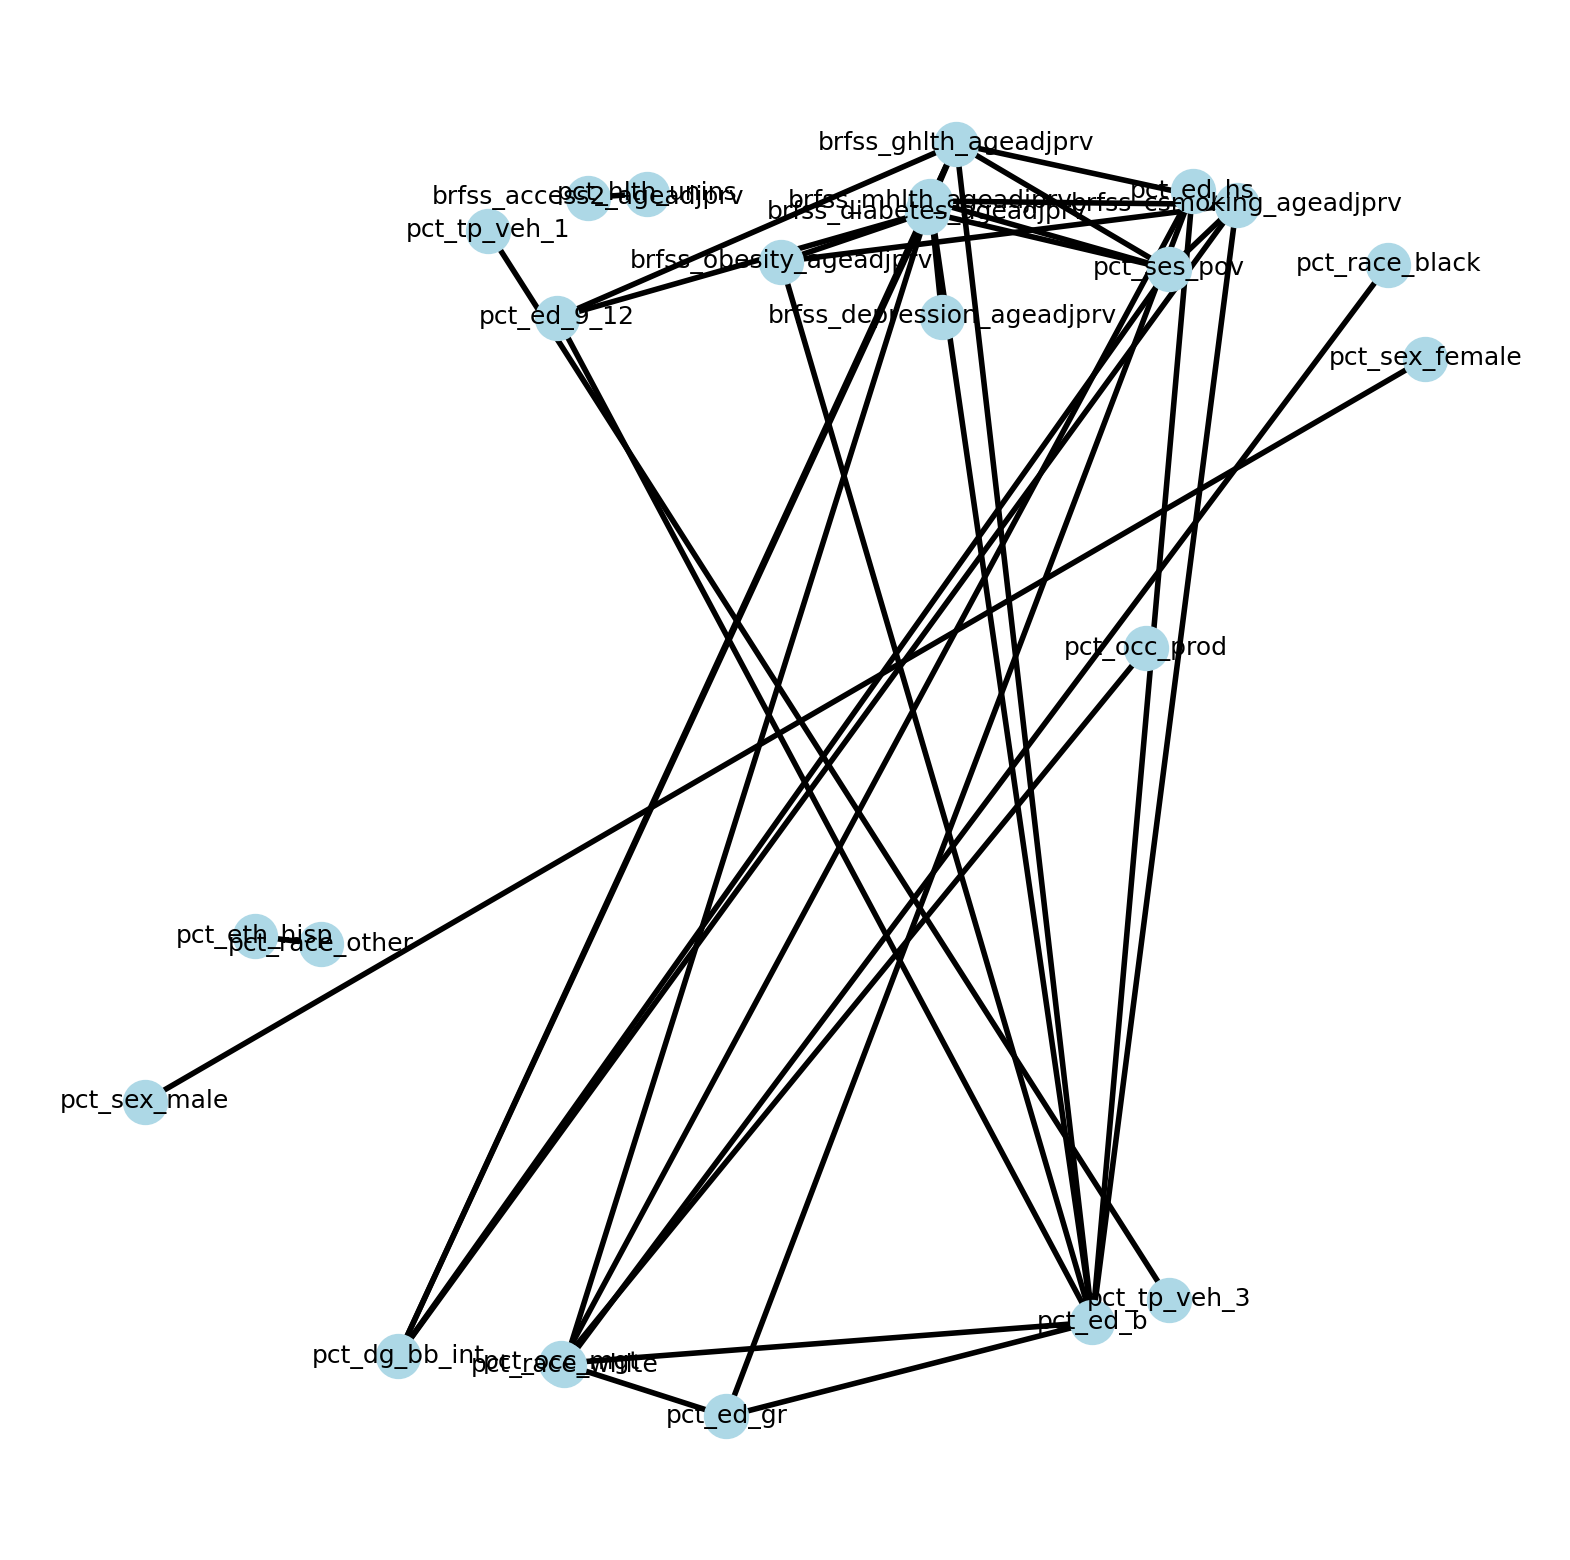

In [360]:
G = nx.Graph()
for feature1, feature2, correlation in top_bottom.values:
    if abs(correlation) > 0.60:
        G.add_edge(feature1, feature2, weight=correlation)

pos = nx.spring_layout(G)
edges = G.edges(data=True)
plt.figure(figsize=(20, 20))

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=4)
nx.draw_networkx_labels(G, pos, font_size=18, font_family='sans-serif')
plt.axis('off')
plt.show()


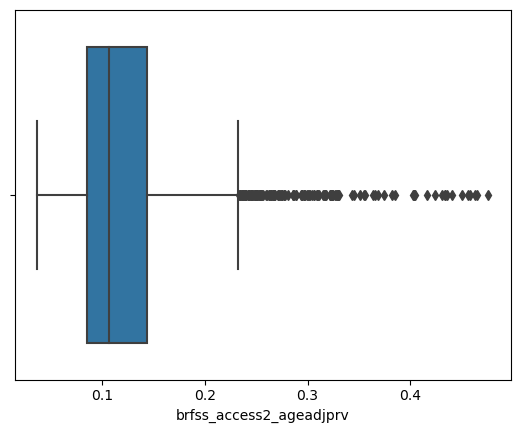

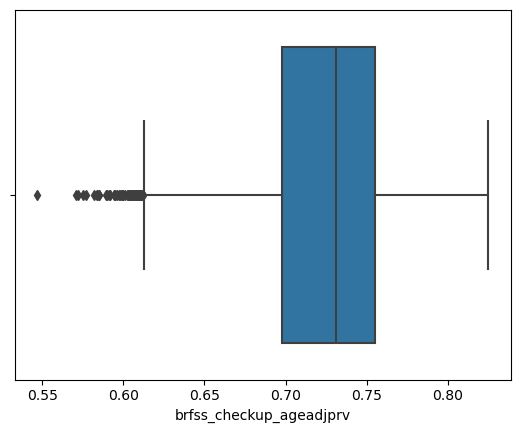

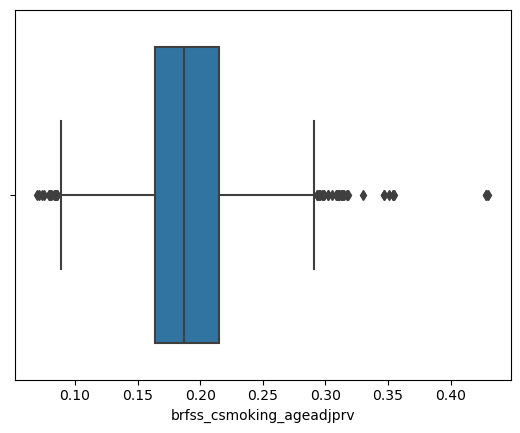

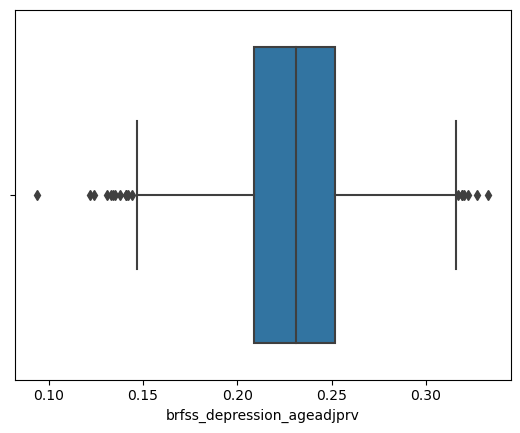

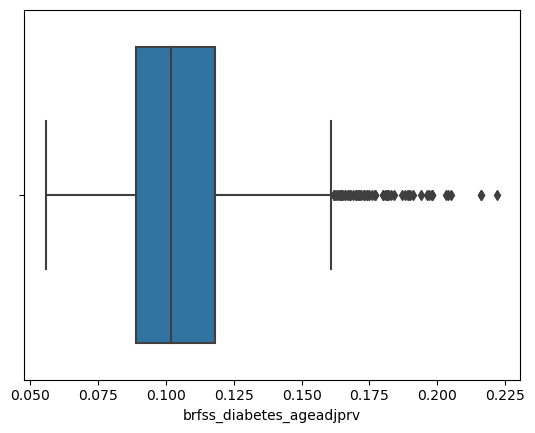

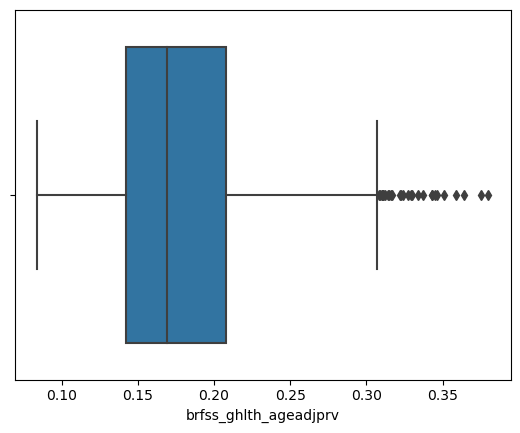

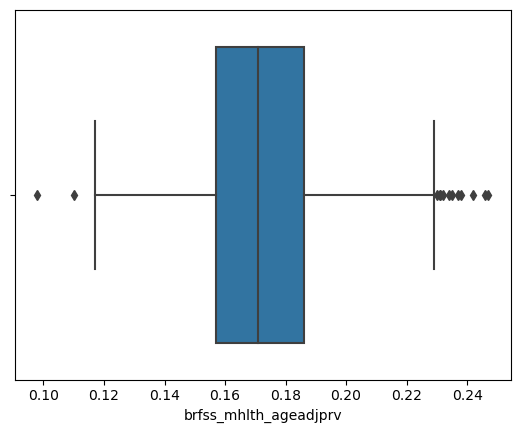

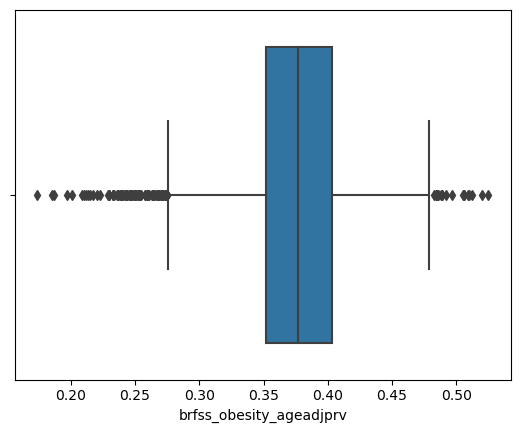

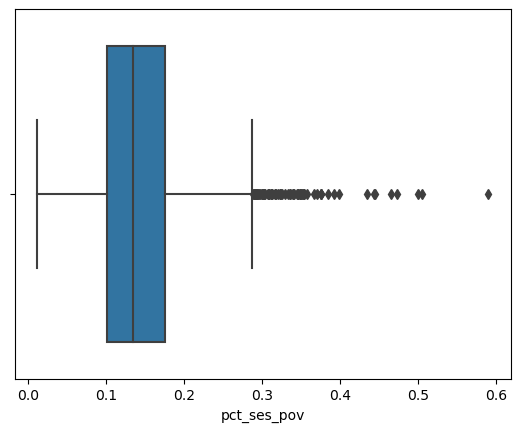

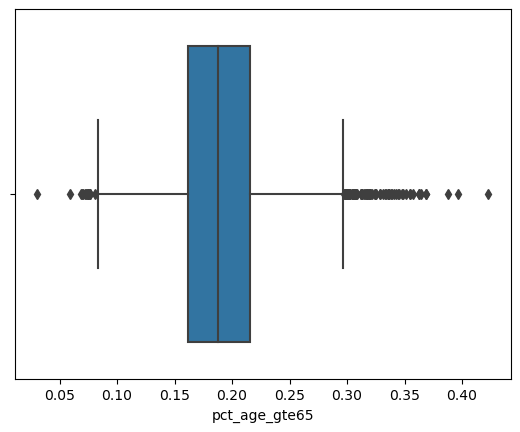

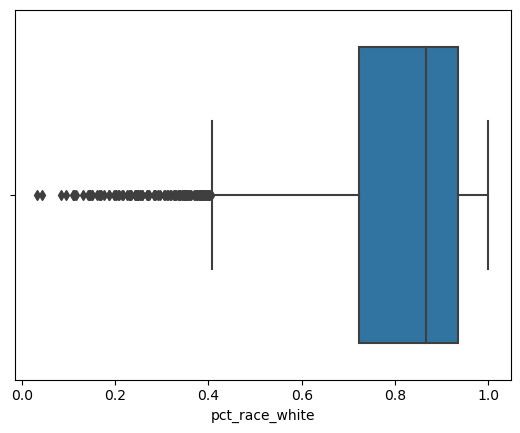

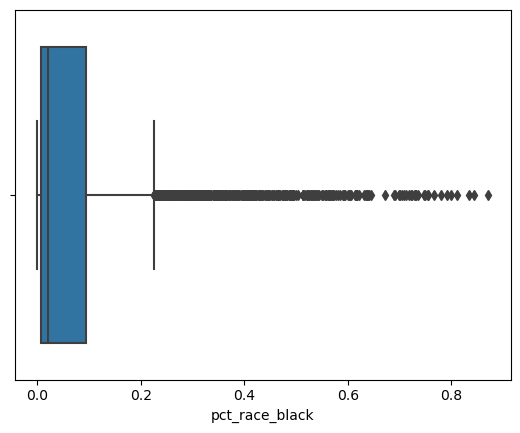

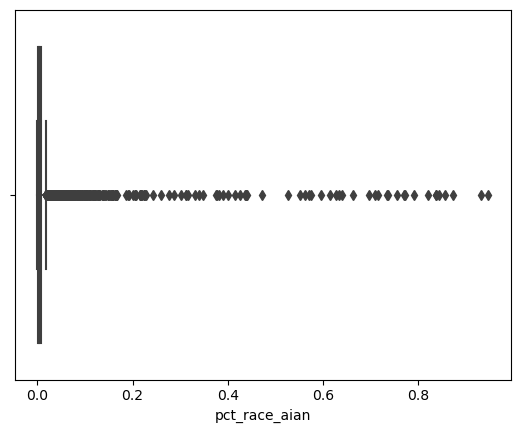

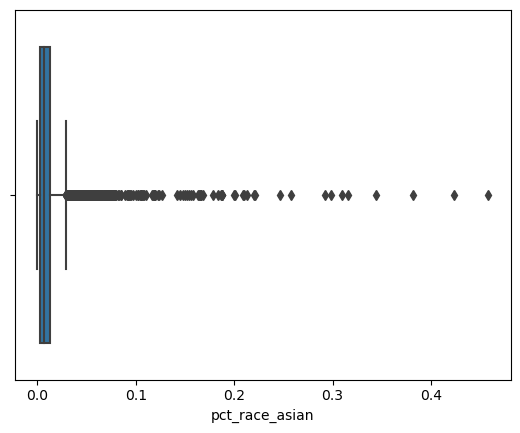

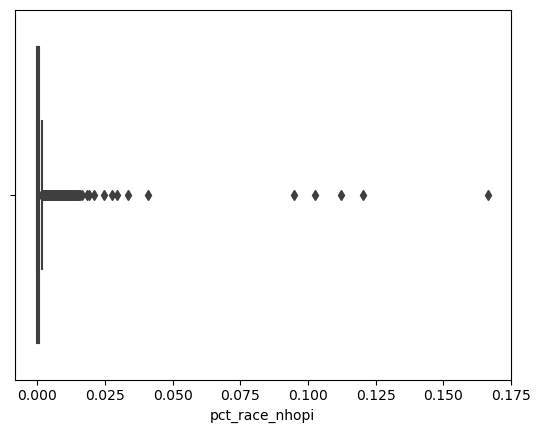

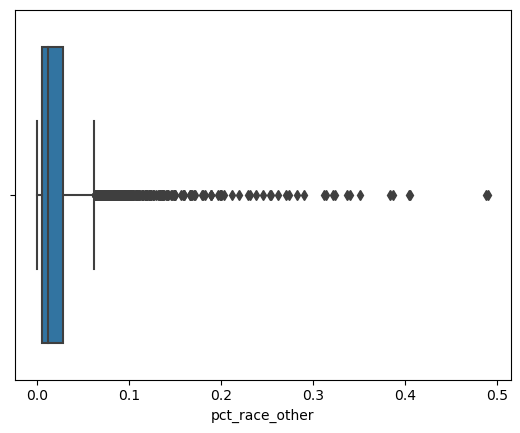

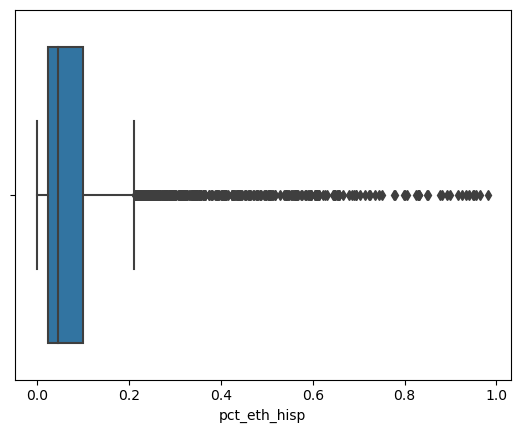

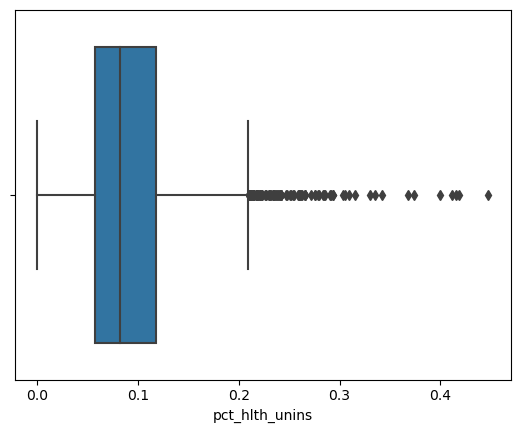

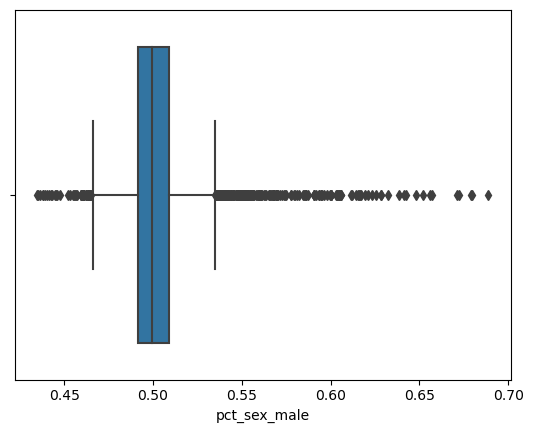

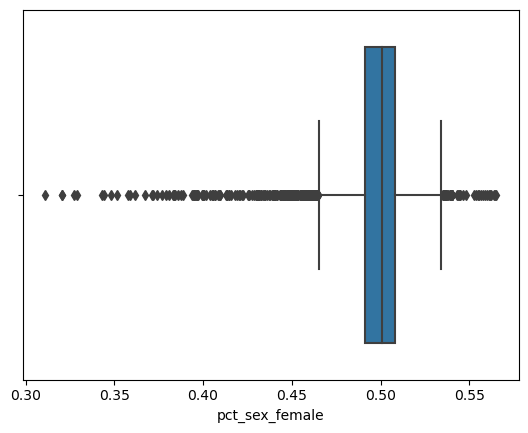

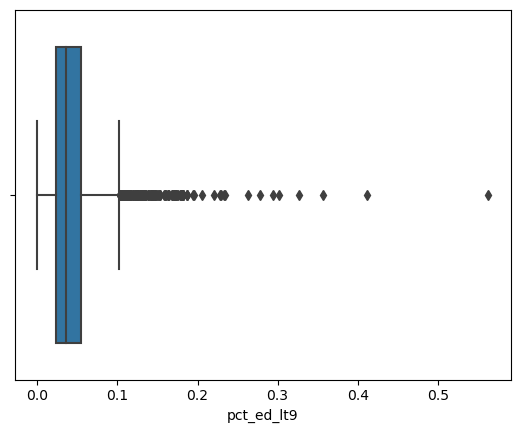

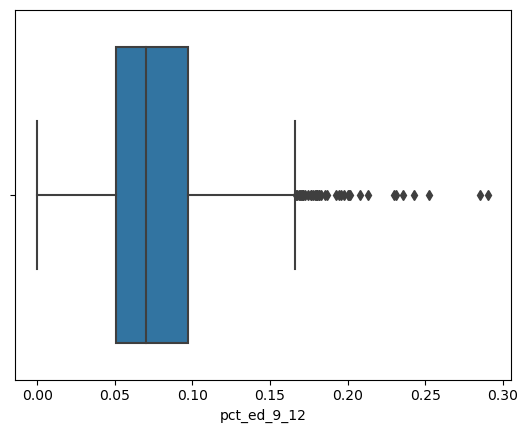

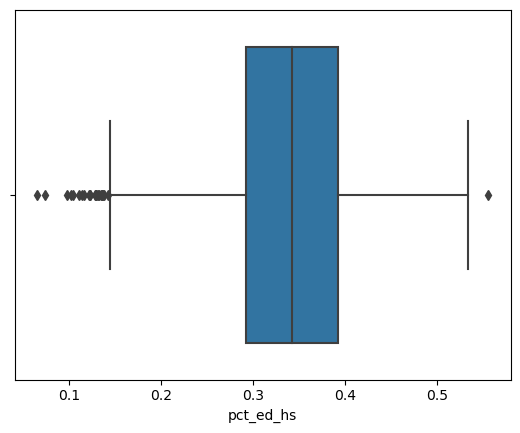

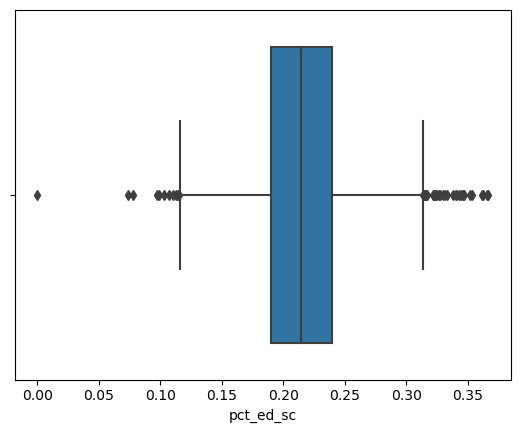

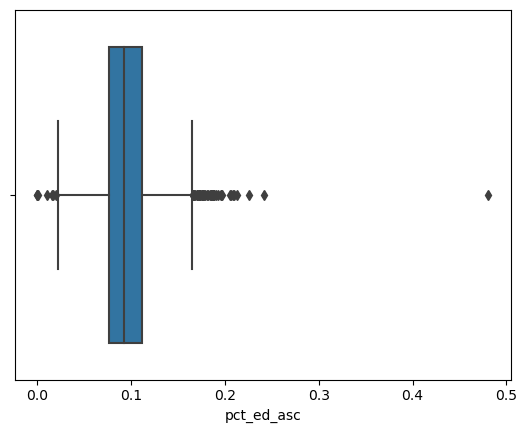

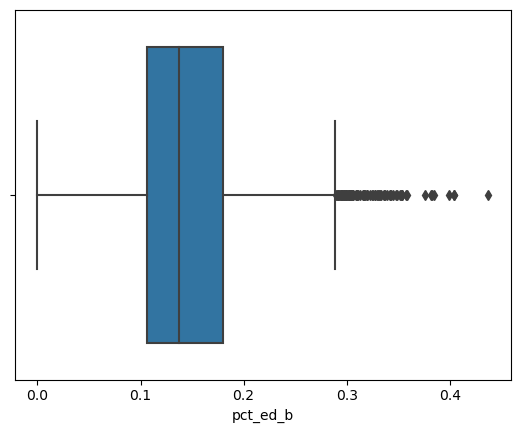

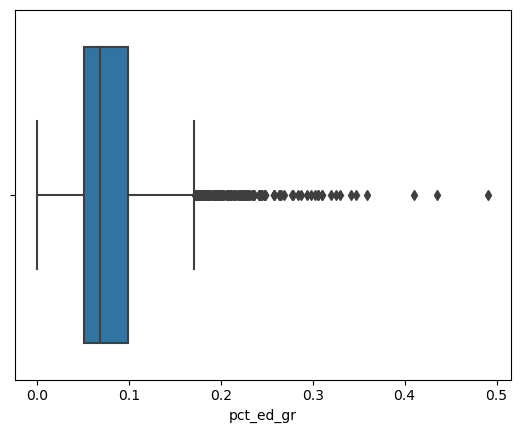

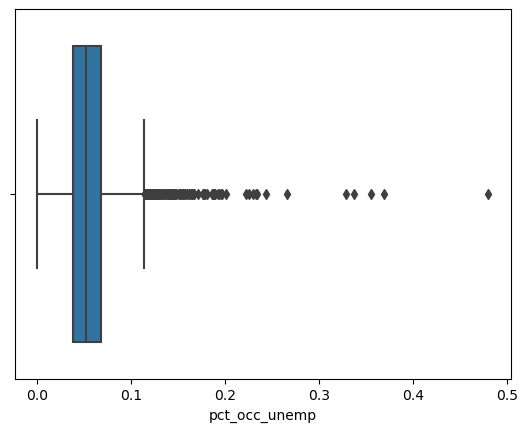

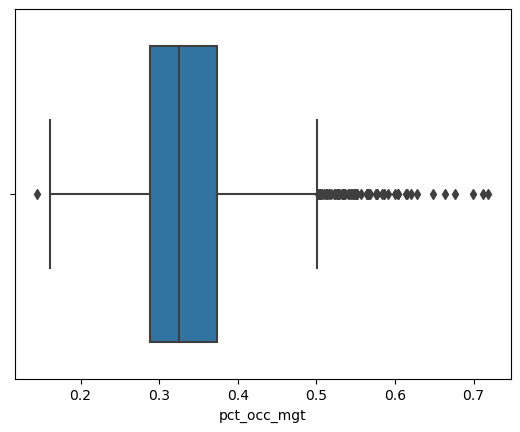

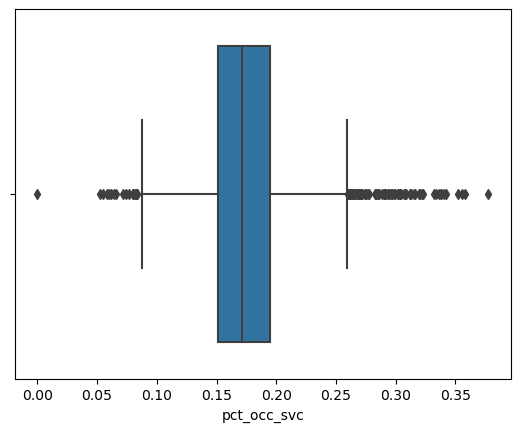

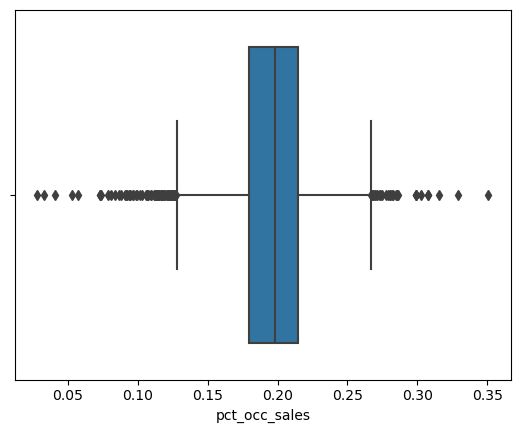

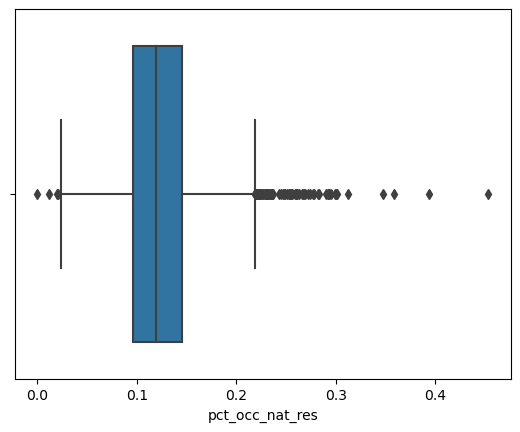

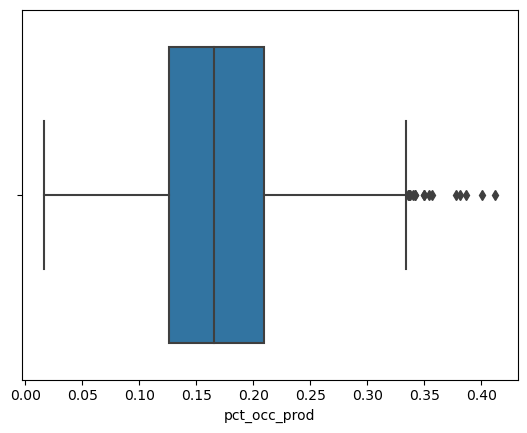

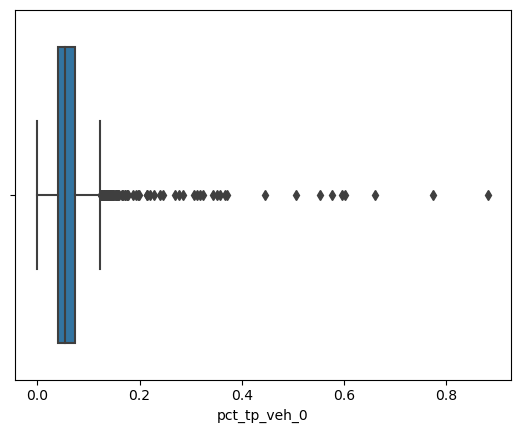

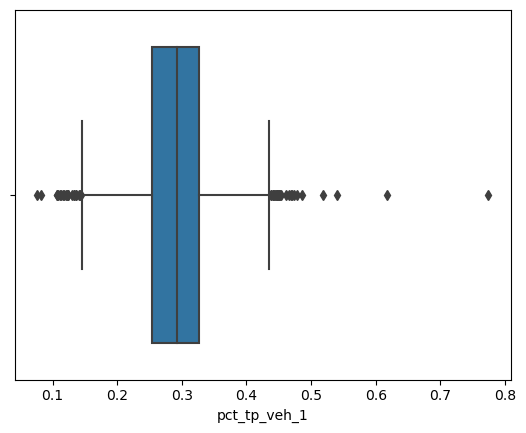

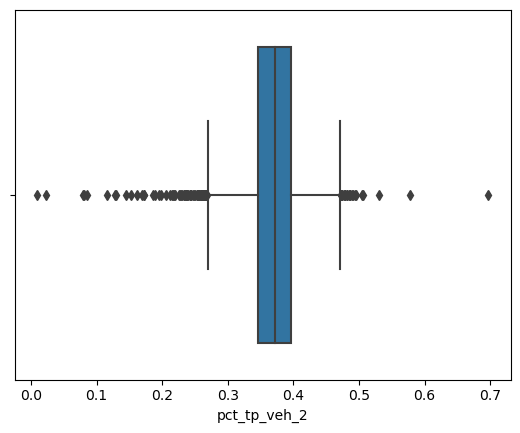

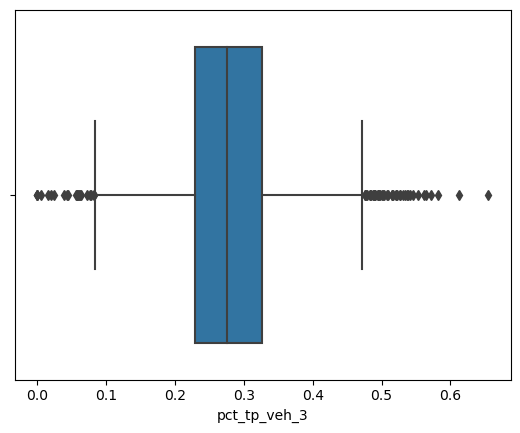

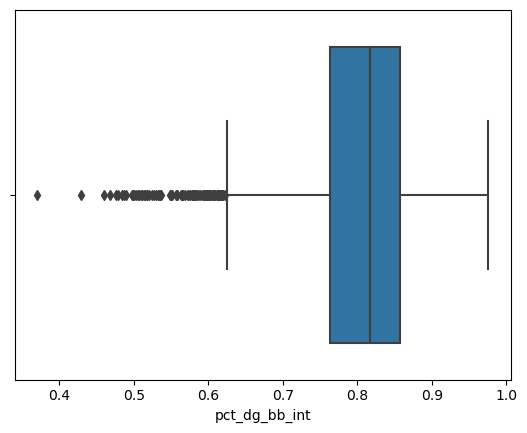

In [375]:
#box plots for all feautres seaborn
for i in df[features]:
    sns.boxplot(x=df[i])
    plt.show()